In [1]:
###############################################################################
# The Institute for the Design of Advanced Energy Systems Integrated Platform
# Framework (IDAES IP) was produced under the DOE Institute for the
# Design of Advanced Energy Systems (IDAES).
#
# Copyright (c) 2018-2023 by the software owners: The Regents of the
# University of California, through Lawrence Berkeley National Laboratory,
# National Technology & Engineering Solutions of Sandia, LLC, Carnegie Mellon
# University, West Virginia University Research Corporation, et al.
# All rights reserved.  Please see the files COPYRIGHT.md and LICENSE.md
# for full copyright and license information.
###############################################################################

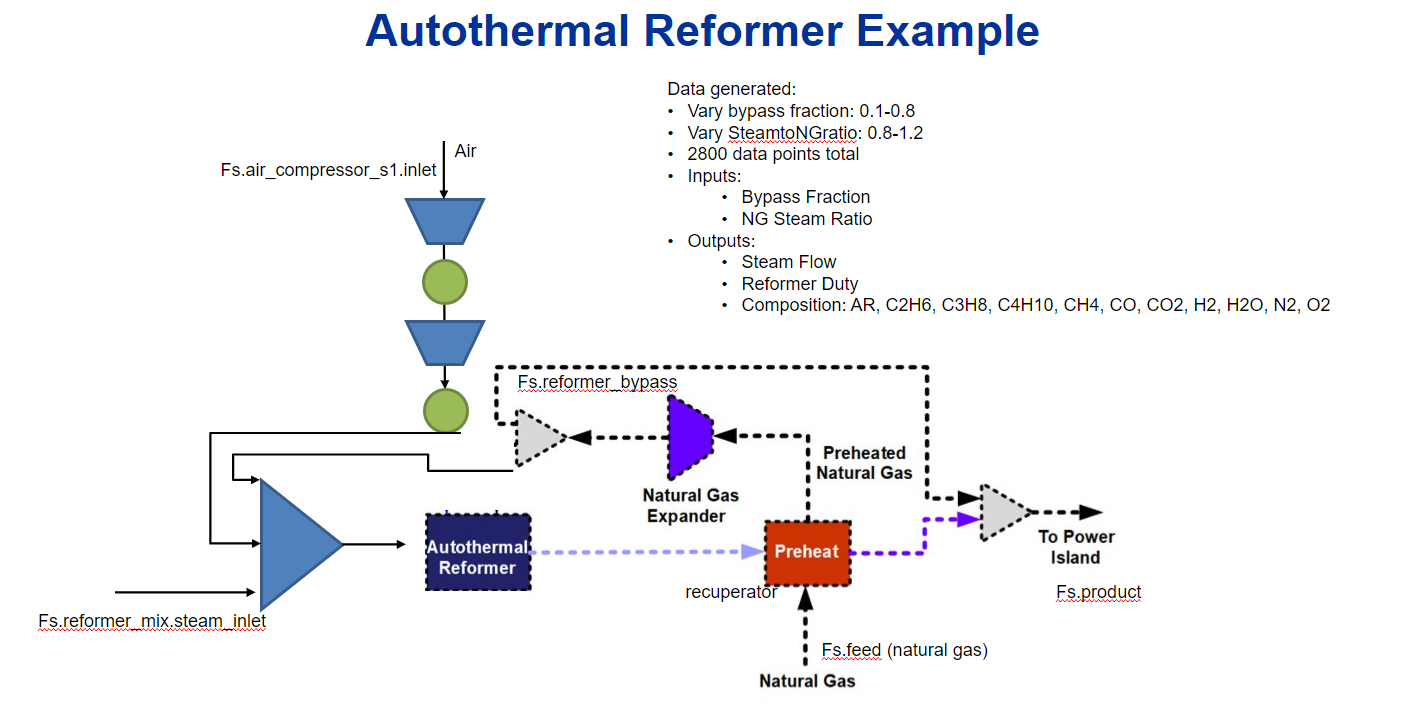

In [2]:
from IPython.display import Image
from pathlib import Path


def datafile_path(name):
    return Path("..") / name


Image(datafile_path("AR_PFD.png"))

In [3]:
# Import statements
import os
import numpy as np
import pandas as pd

# Import Pyomo libraries
from pyomo.environ import (
    ConcreteModel,
    SolverFactory,
    value,
    Var,
    Constraint,
    Set,
    Objective,
    maximize,
)
from pyomo.common.timing import TicTocTimer

# Import IDAES libraries
from idaes.core.surrogate.sampling.data_utils import split_training_validation
from idaes.core.surrogate.pysmo_surrogate import PysmoPolyTrainer, PysmoSurrogate
from idaes.core.surrogate.plotting.sm_plotter import (
    surrogate_scatter2D,
    surrogate_parity,
    surrogate_residual,
)
from idaes.core.surrogate.surrogate_block import SurrogateBlock
from idaes.core import FlowsheetBlock
from idaes.core.util.convergence.convergence_base import _run_ipopt_with_stats

In [4]:
# Import Auto-reformer training data
np.set_printoptions(precision=6, suppress=True)

csv_data = pd.read_csv(datafile_path("reformer-data.csv"))  # 2800 data points
data = csv_data.sample(n=100)  # randomly sample points for training/validation
input_data = data.iloc[:, :2]
output_data = data.iloc[:, 2:]

# Define labels, and split training and validation data
# note that PySMO requires that labels are passed as string lists
input_labels = list(input_data.columns)
output_labels = list(output_data.columns)

n_data = data[input_labels[0]].size
data_training, data_validation = split_training_validation(
    data, 0.8, seed=n_data
)  # seed=100

In [5]:
# capture long output (not required to use surrogate API)
from io import StringIO
import sys

stream = StringIO()
oldstdout = sys.stdout
sys.stdout = stream

# Create PySMO trainer object
trainer = PysmoPolyTrainer(
    input_labels=input_labels,
    output_labels=output_labels,
    training_dataframe=data_training,
)

# Set PySMO options
trainer.config.maximum_polynomial_order = 6
trainer.config.multinomials = True
trainer.config.training_split = 0.8
trainer.config.number_of_crossvalidations = 10

# Train surrogate (calls PySMO through IDAES Python wrapper)
poly_train = trainer.train_surrogate()

# create callable surrogate object
xmin, xmax = [0.1, 0.8], [0.8, 1.2]
input_bounds = {input_labels[i]: (xmin[i], xmax[i]) for i in range(len(input_labels))}
poly_surr = PysmoSurrogate(poly_train, input_labels, output_labels, input_bounds)

# save model to JSON
model = poly_surr.save_to_file("pysmo_poly_surrogate.json", overwrite=True)

# revert back to normal output capture
sys.stdout = oldstdout

# display first 50 lines and last 50 lines of output
celloutput = stream.getvalue().split("\n")
for line in celloutput[:50]:
    print(line)
print(".")
print(".")
print(".")
for line in celloutput[-50:]:
    print(line)

2023-02-18 11:56:50 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output Steam_Flow trained successfully


2023-02-18 11:56:57 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output Reformer_Duty trained successfully


2023-02-18 11:57:03 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output AR trained successfully


2023-02-18 11:57:09 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output C2H6 trained successfully


2023-02-18 11:57:16 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output C3H8 trained successfully


2023-02-18 11:57:22 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output C4H10 trained successfully


2023-02-18 11:57:28 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output CH4 trained successfully


2023-02-18 11:57:34 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output CO trained successfully


2023-02-18 11:57:41 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output CO2 trained successfully


2023-02-18 11:57:47 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output H2 trained successfully


2023-02-18 11:57:53 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output H2O trained successfully


2023-02-18 11:58:00 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output N2 trained successfully


2023-02-18 11:58:06 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output O2 trained successfully



===========================Polynomial Regression===============================================


No iterations will be run.
Default parameter estimation method is used.
Parameter estimation method:  pyomo 

max_fraction_training_samples set at  0.5
Number of adaptive samples (no_adaptive_samples) set at  4
Maximum number of iterations (Max_iter) set at:  0

Initial surrogate model is of order 3  with a cross-val error of 0.000000
Initial Regression Model Performance:
Order:  3  / MAE: 0.000000  / MSE: 0.000000  / R^2: 1.000000  / Adjusted R^2: 1.000000

Polynomial regression generates a good surrogate model for the input data.

-------------------------------------------------
-------------------------------------------------
Best solution found:  
Order:  3  / MAE: 0.000000  / MSE: 0.000000  / R_sq: 1.000000  / Adjusted R^2: 1.000000

------------------------------------------------------------
The final coefficients of the regression terms are: 

k               | 0.0
(x_ 1 )^ 1   

C:\Users\dang\miniconda3\envs\idaes_main_py310\lib\site-packages\idaes\core\surrogate\pysmo\polynomial_regression.py:1401: UserWarning: Polynomial regression generates poor fit for the dataset
  warnings.warn(


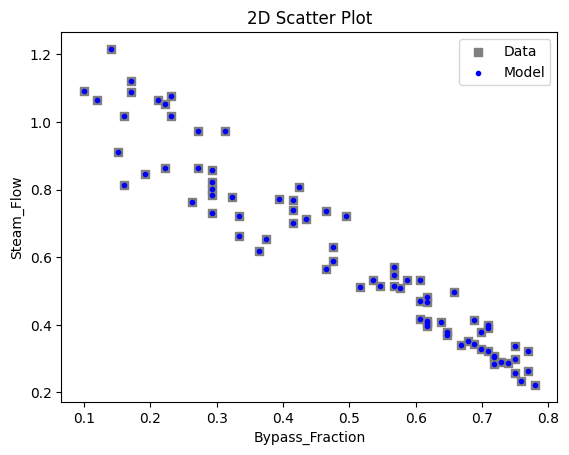

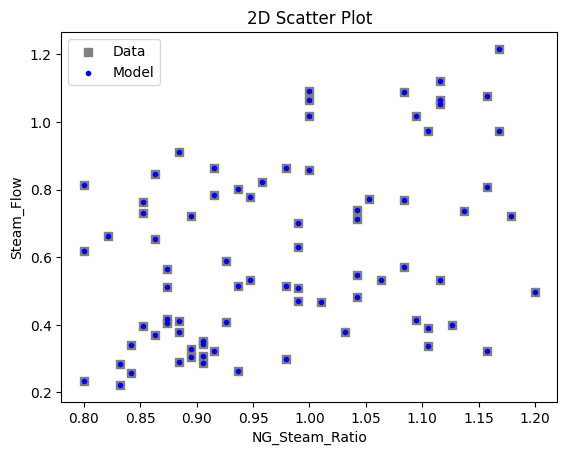

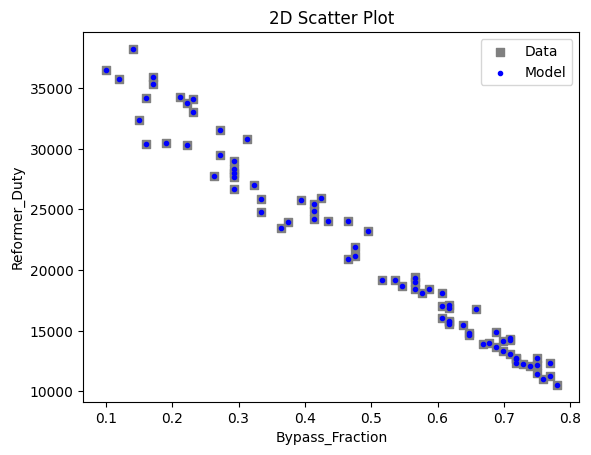

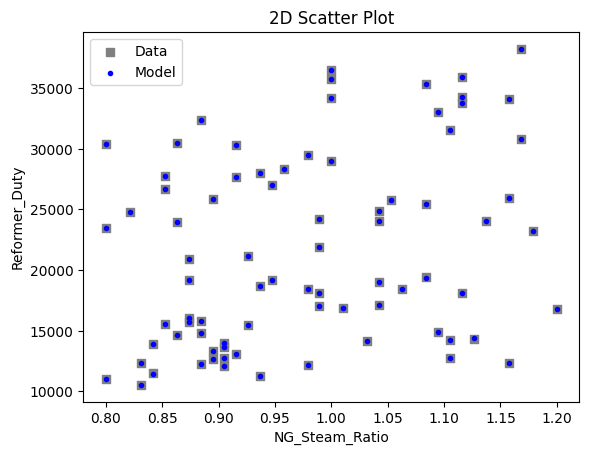

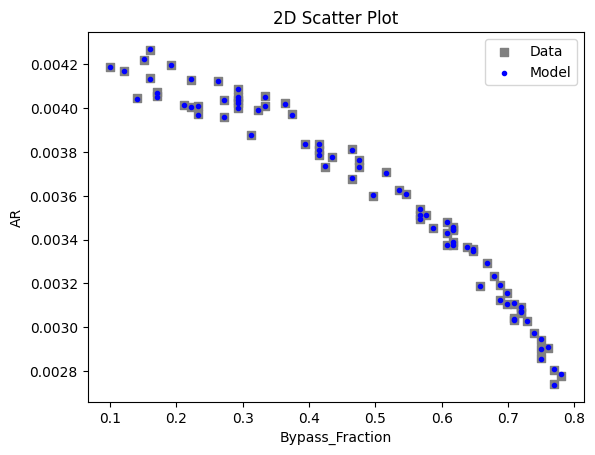

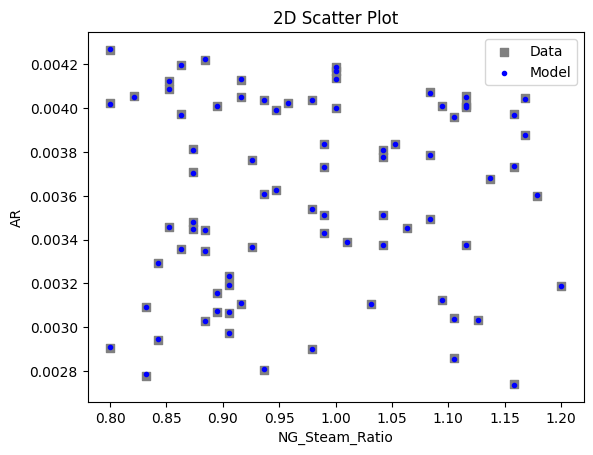

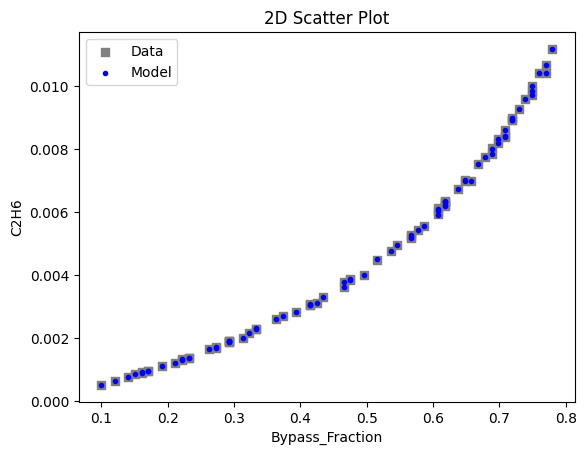

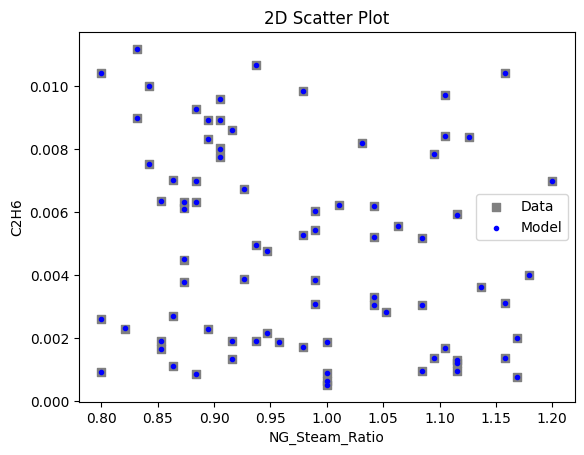

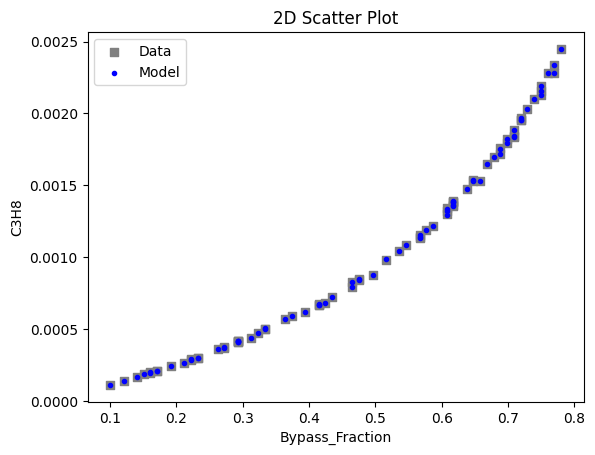

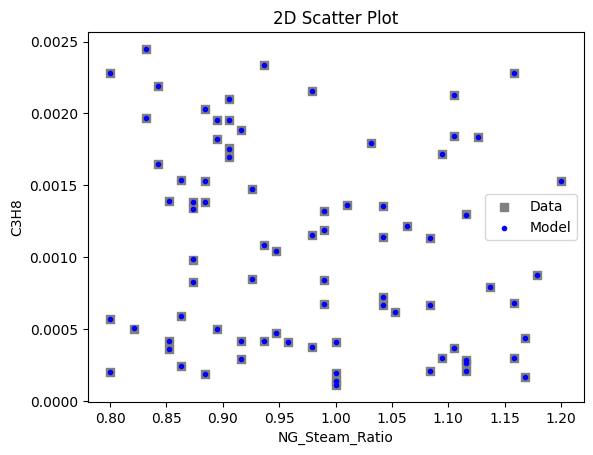

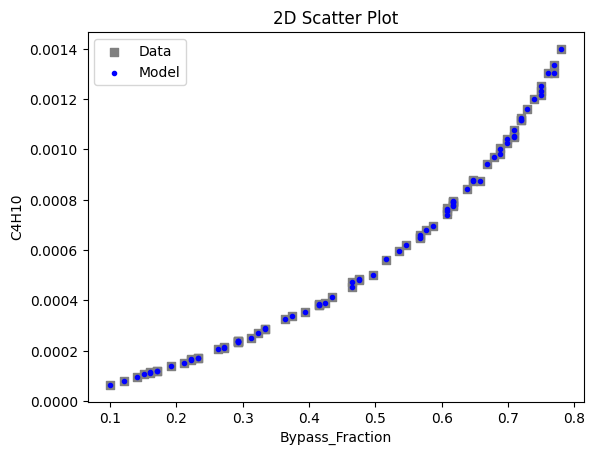

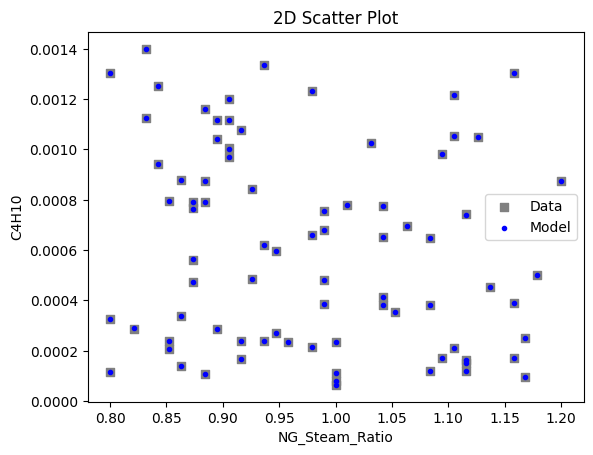

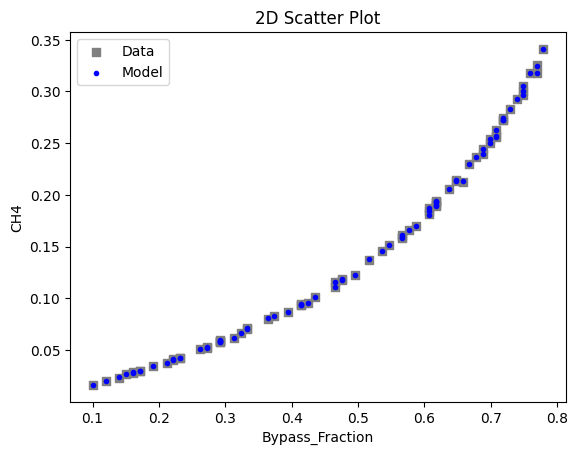

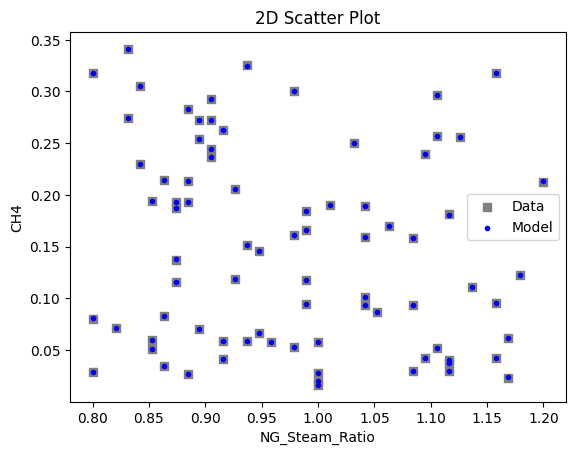

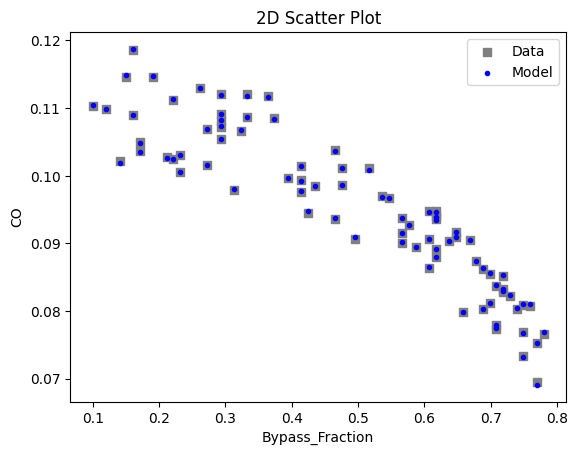

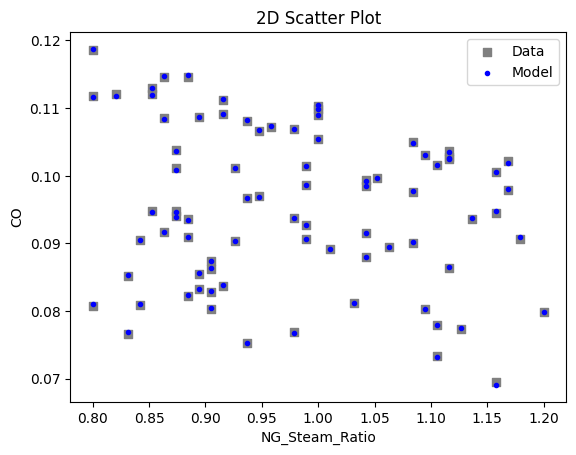

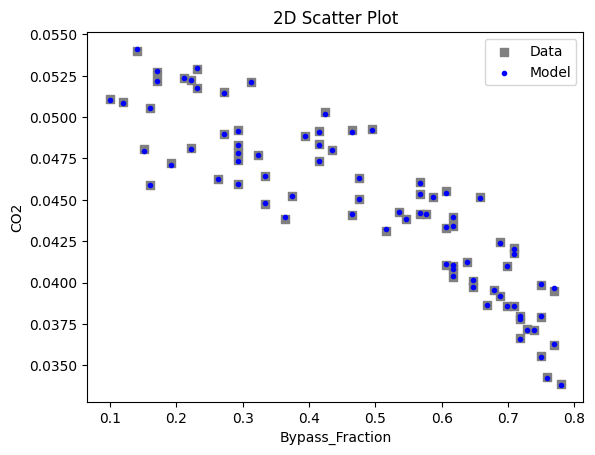

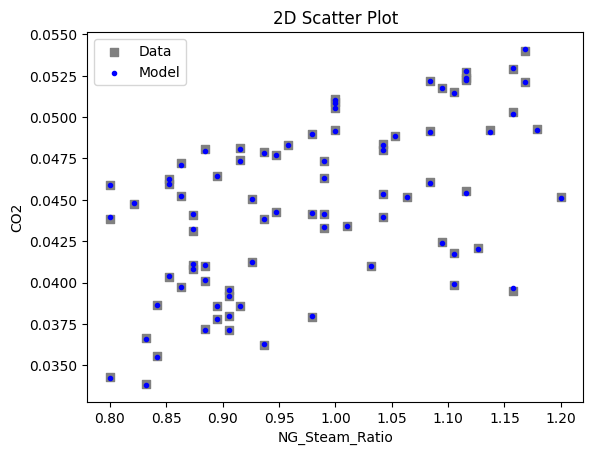

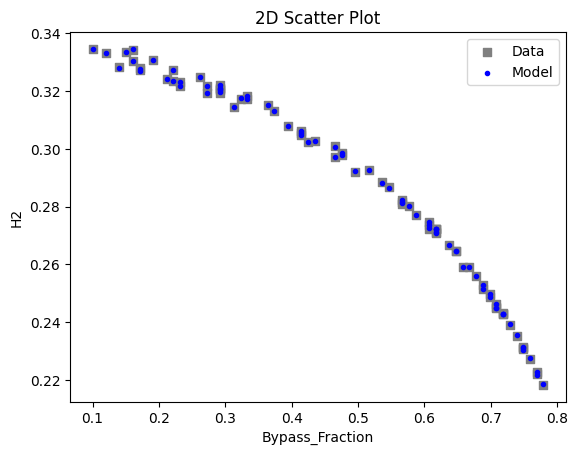

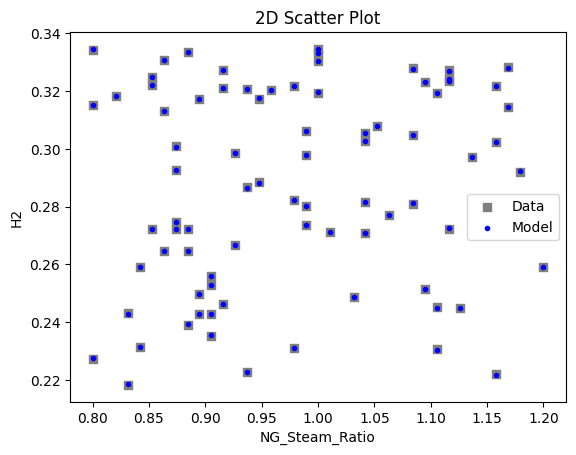

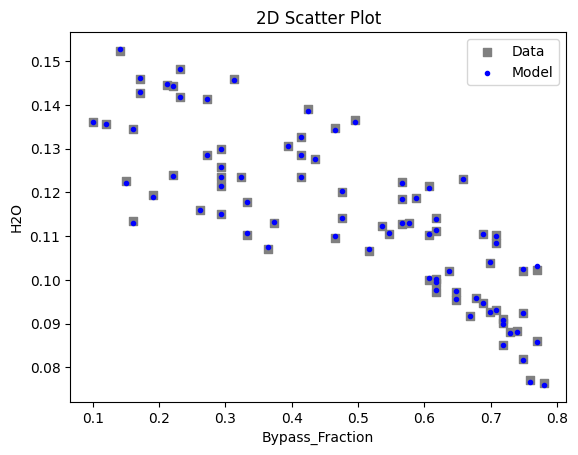

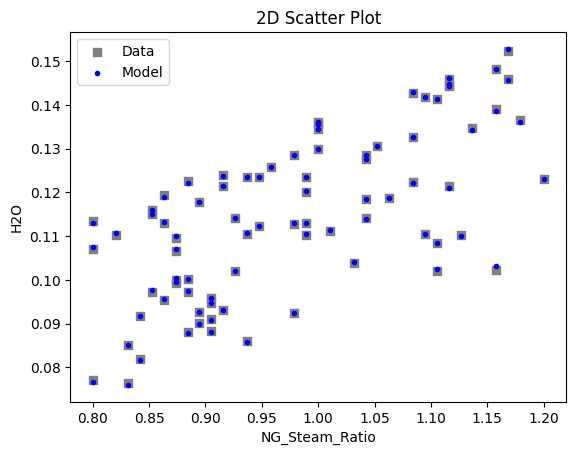

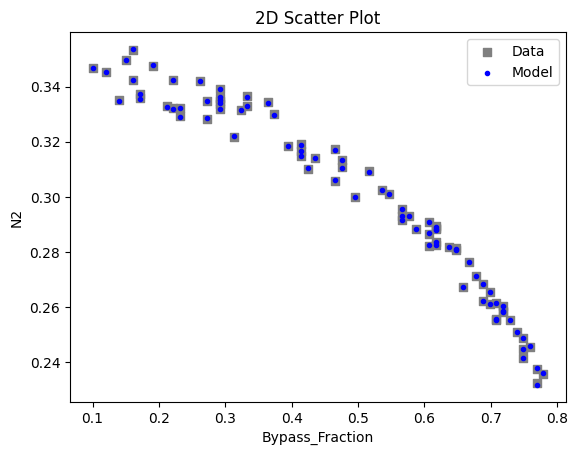

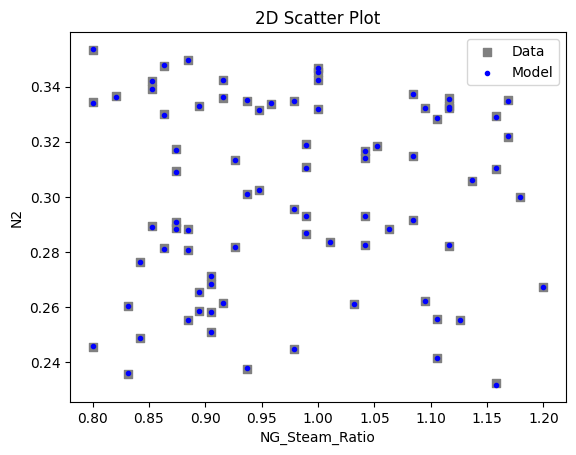

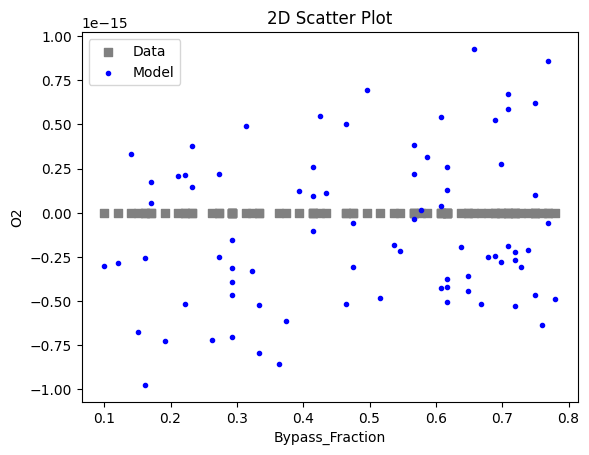

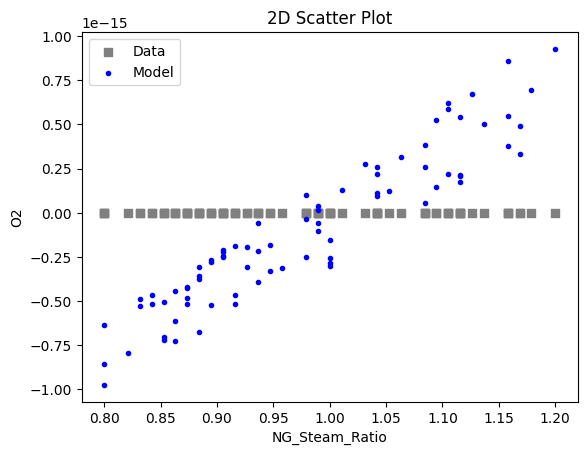

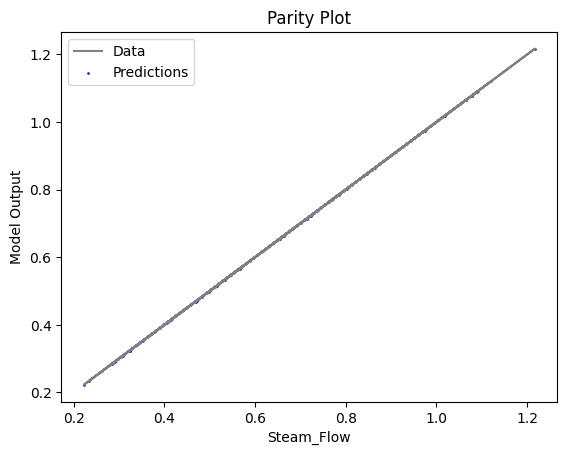

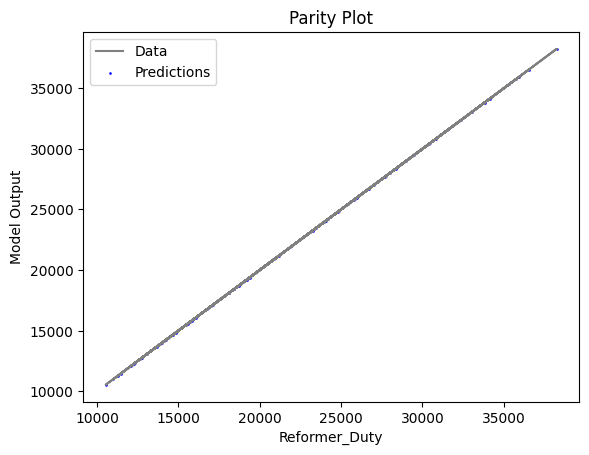

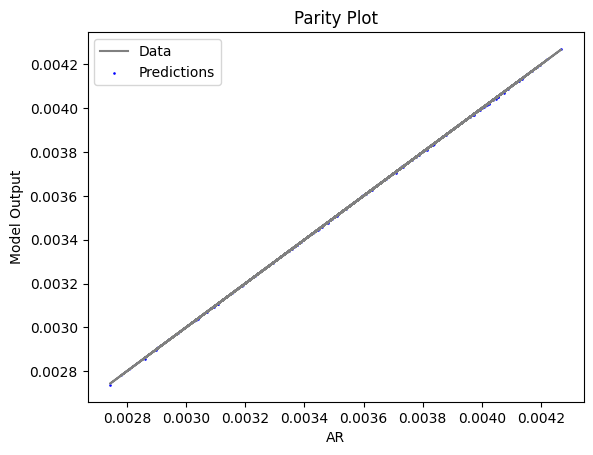

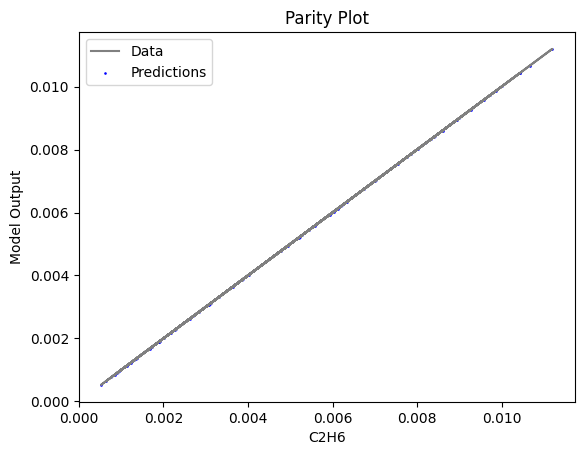

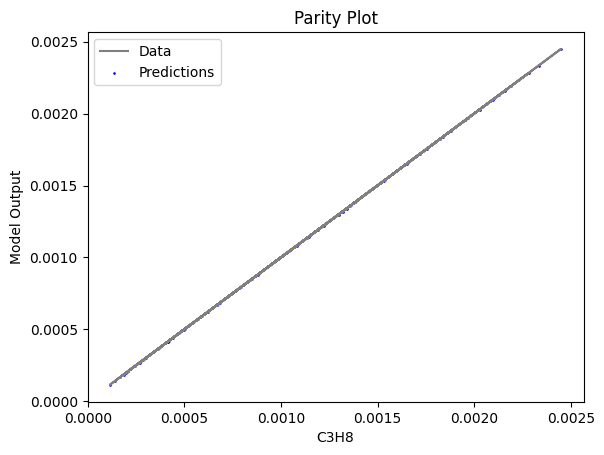

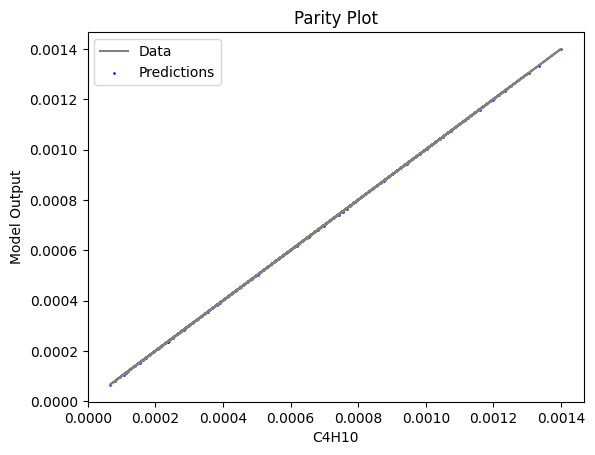

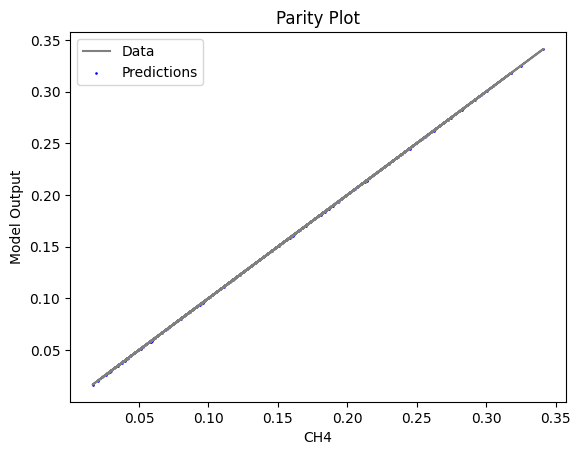

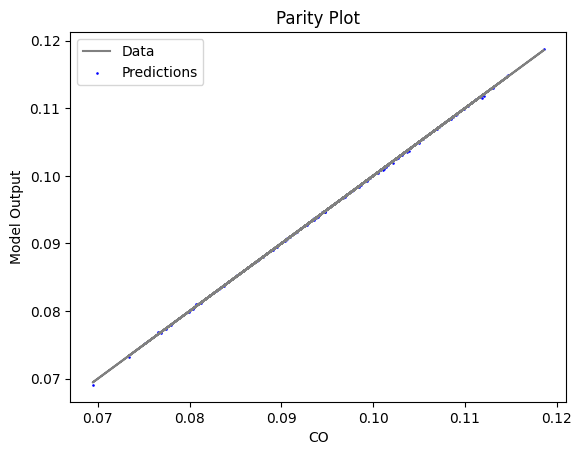

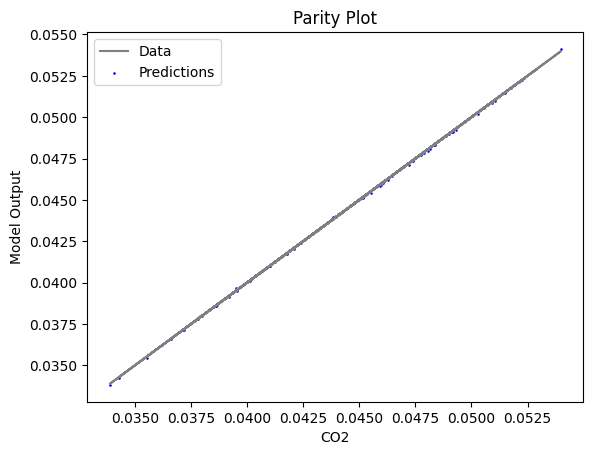

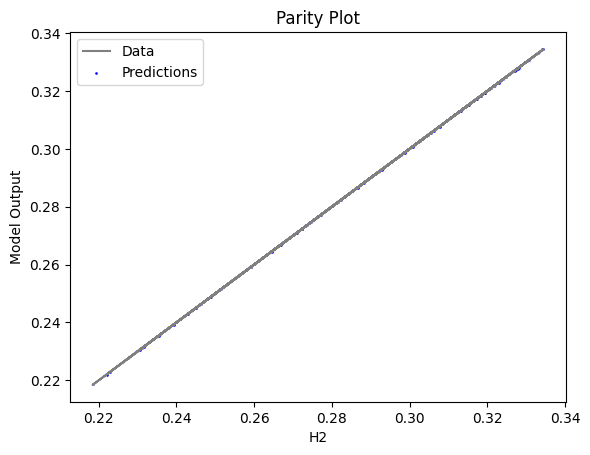

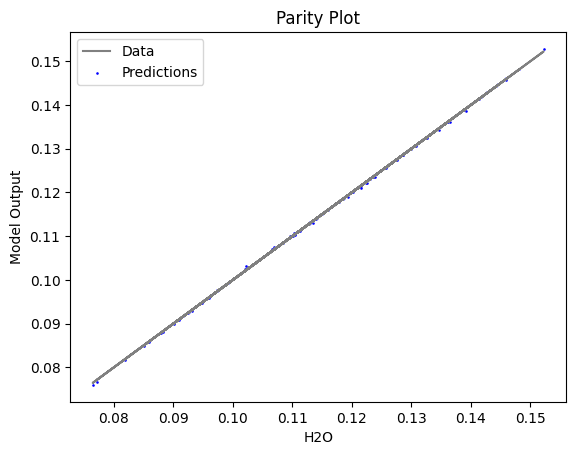

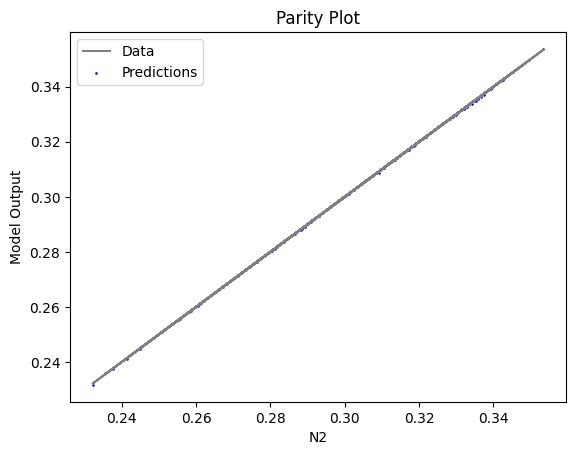

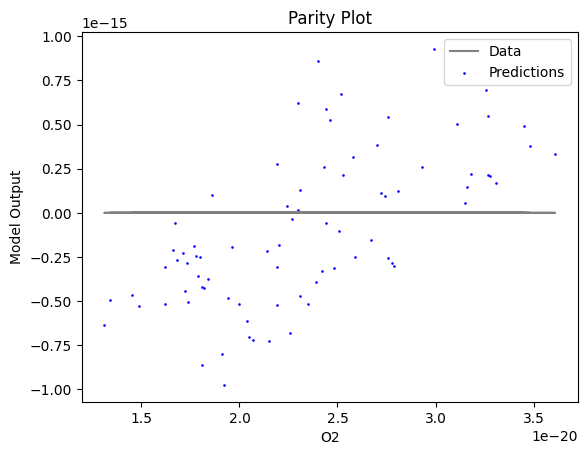

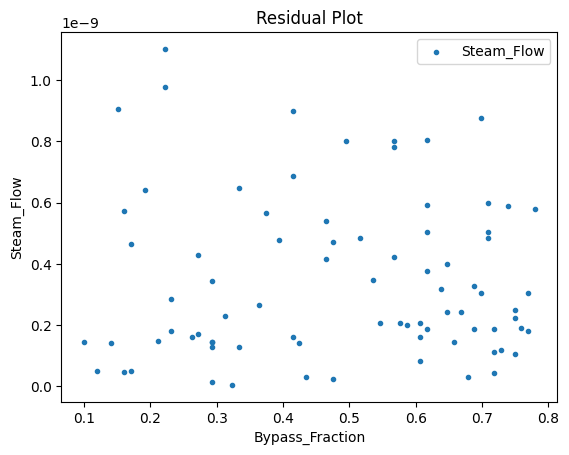

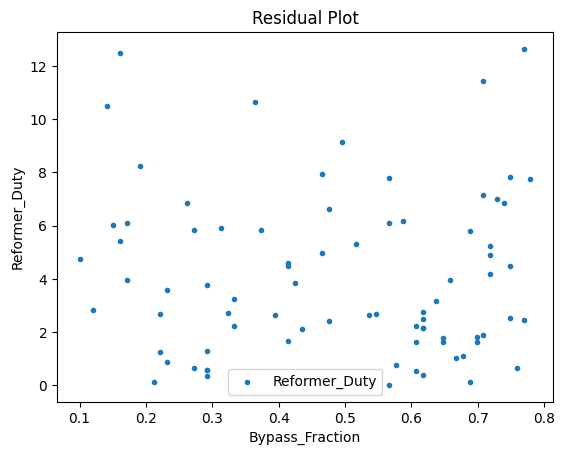

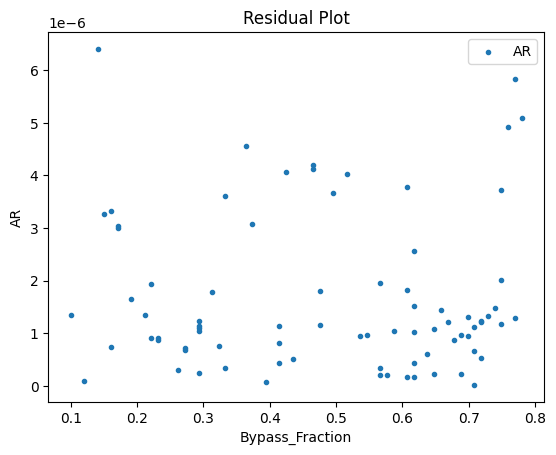

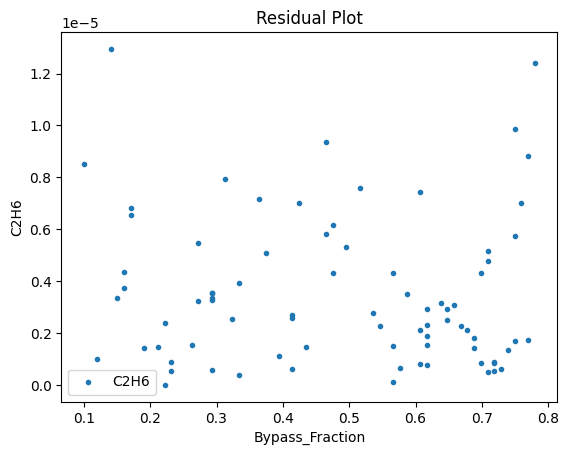

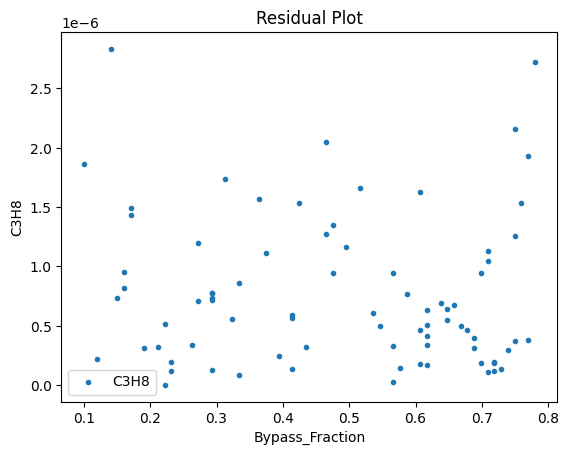

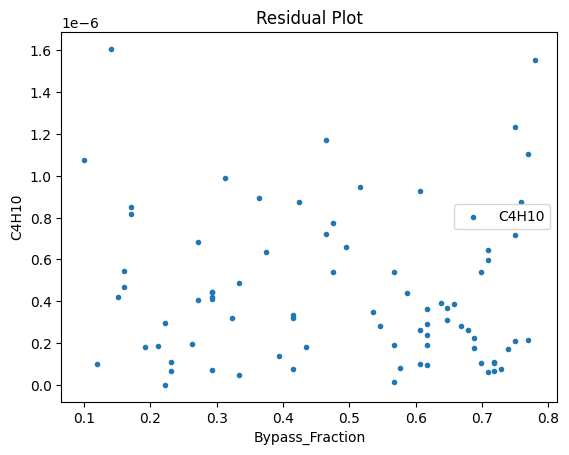

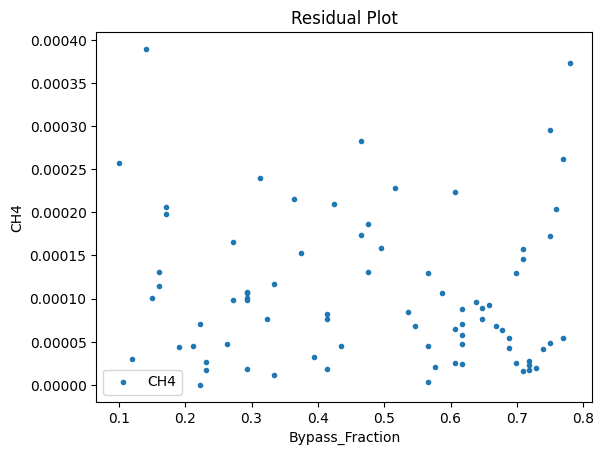

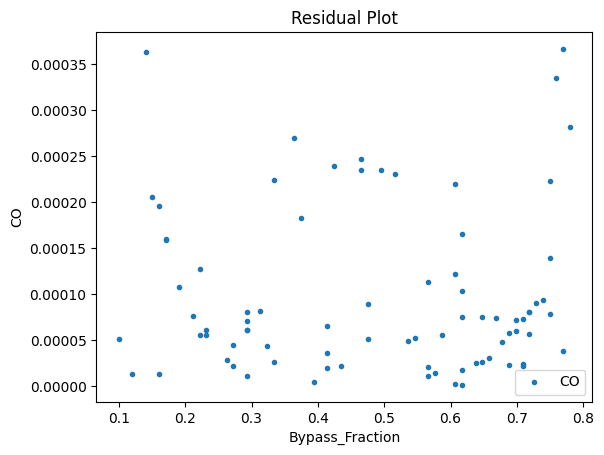

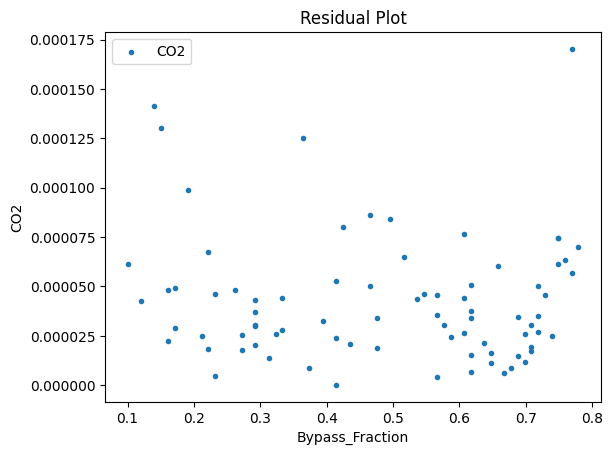

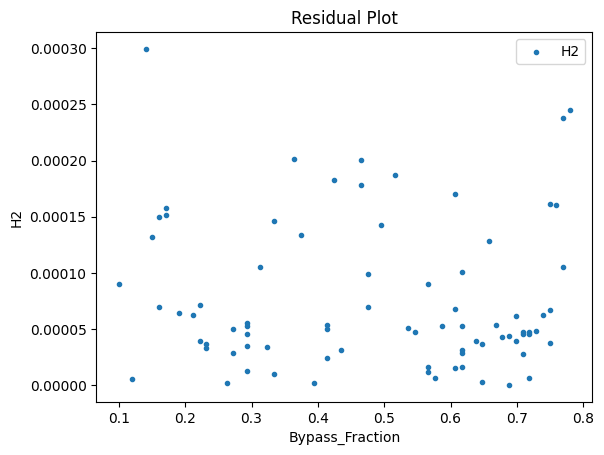

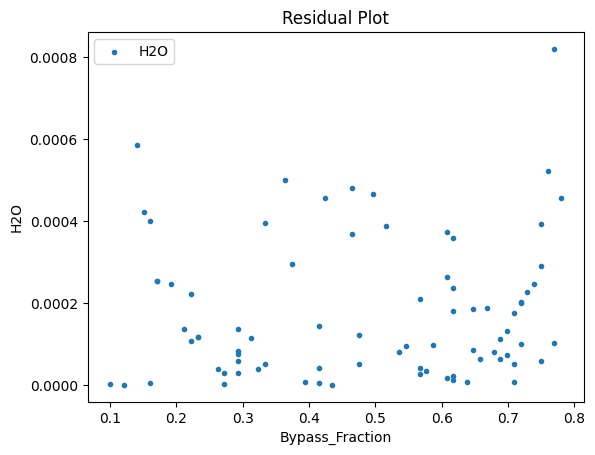

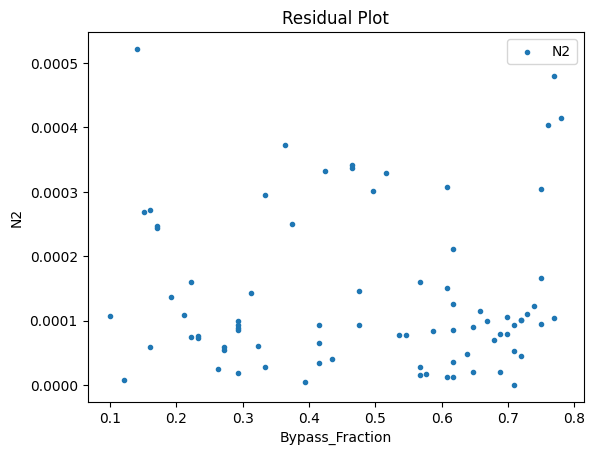

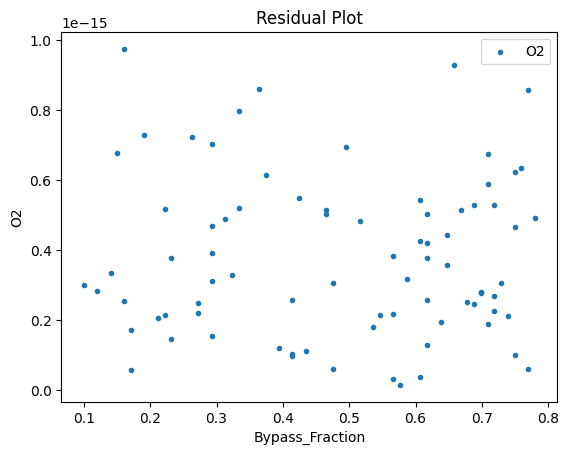

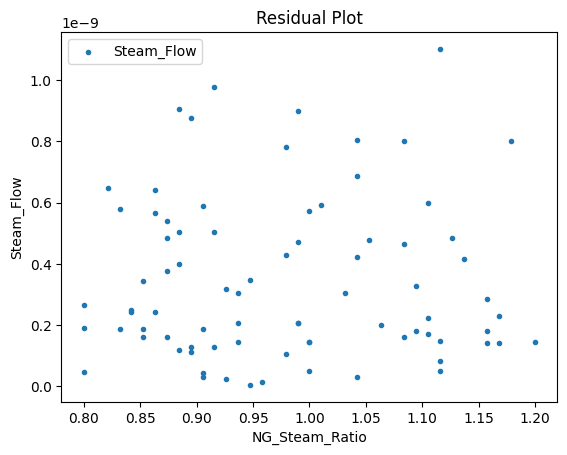

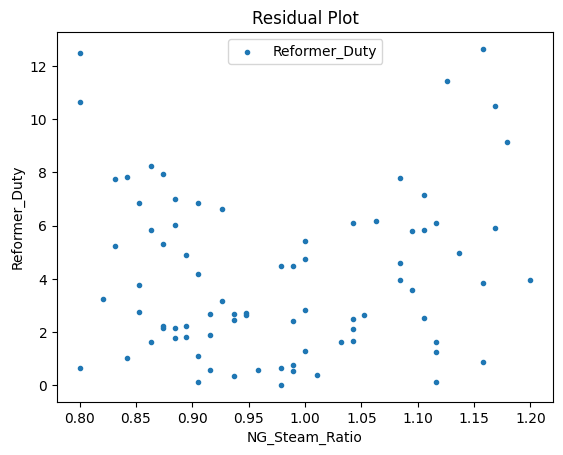

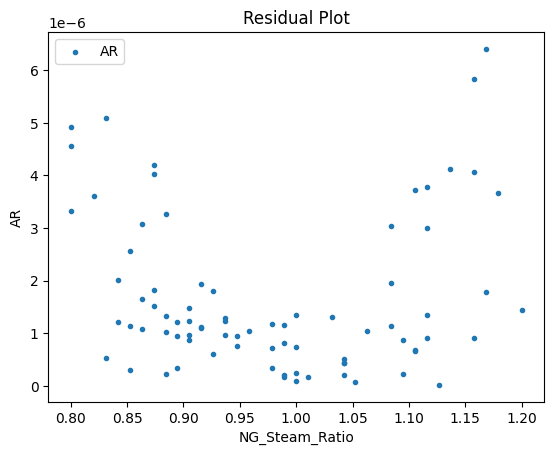

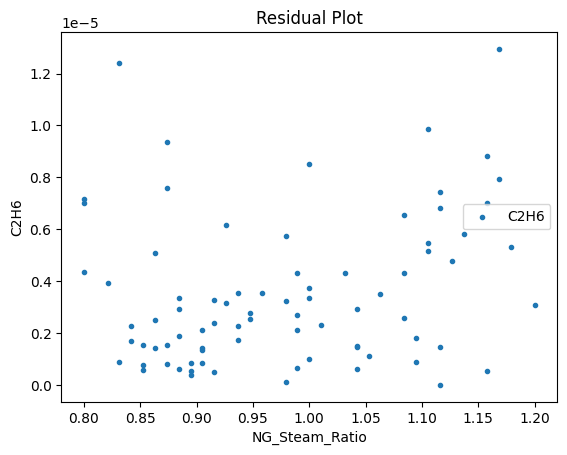

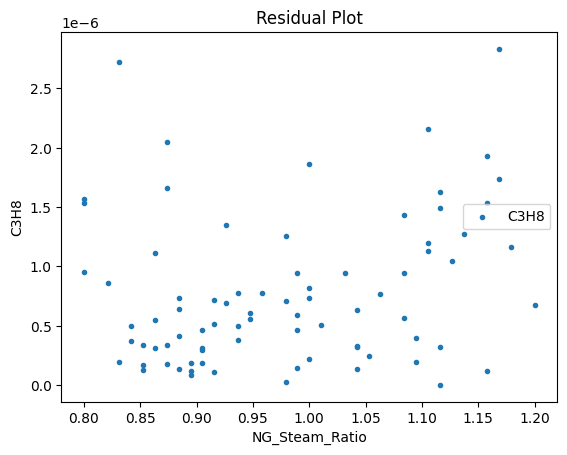

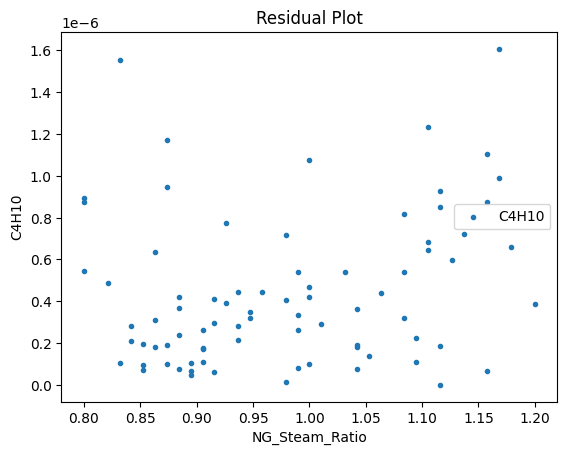

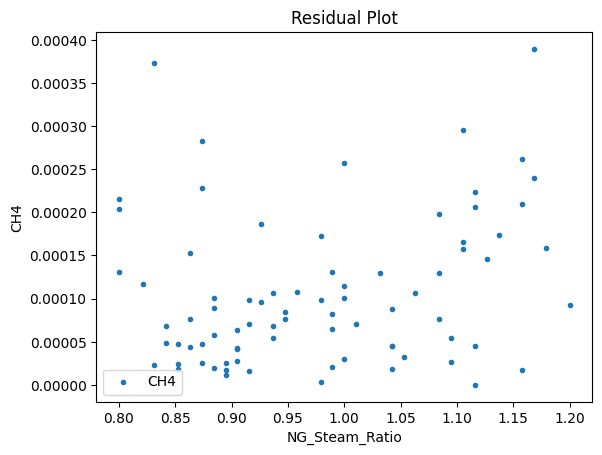

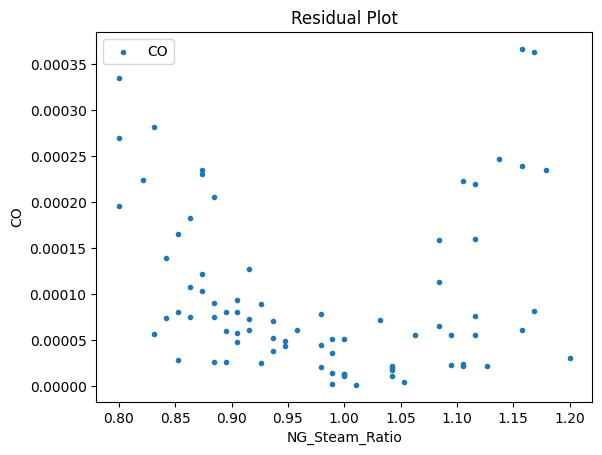

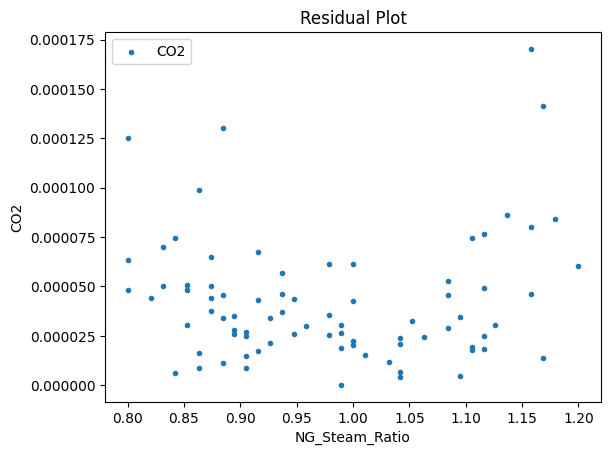

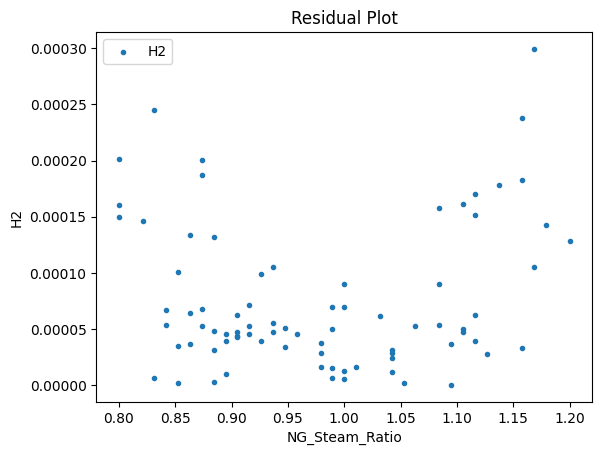

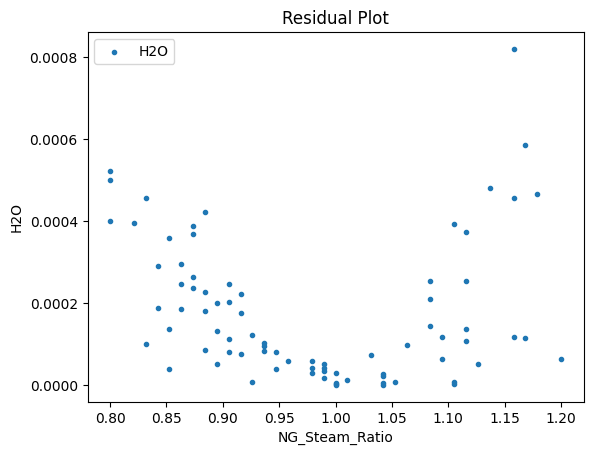

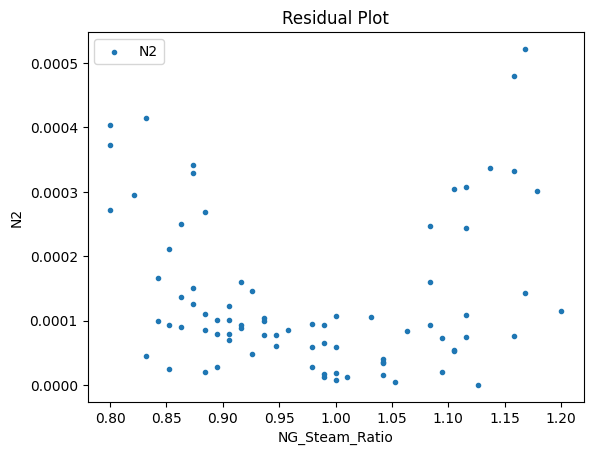

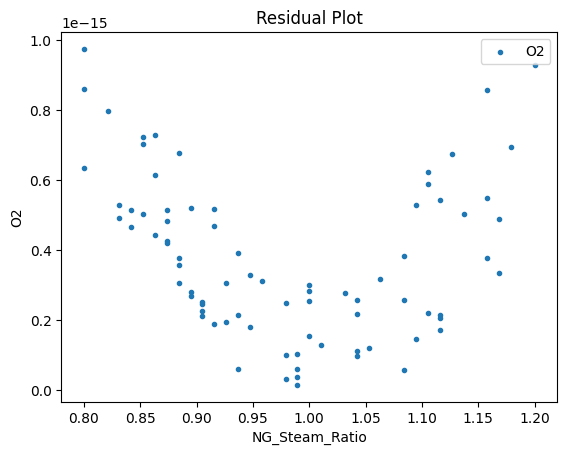

In [6]:
# visualize with IDAES surrogate plotting tools
surrogate_scatter2D(poly_surr, data_training, filename="pysmo_poly_train_scatter2D.pdf")
surrogate_parity(poly_surr, data_training, filename="pysmo_poly_train_parity.pdf")
surrogate_residual(poly_surr, data_training, filename="pysmo_poly_train_residual.pdf")

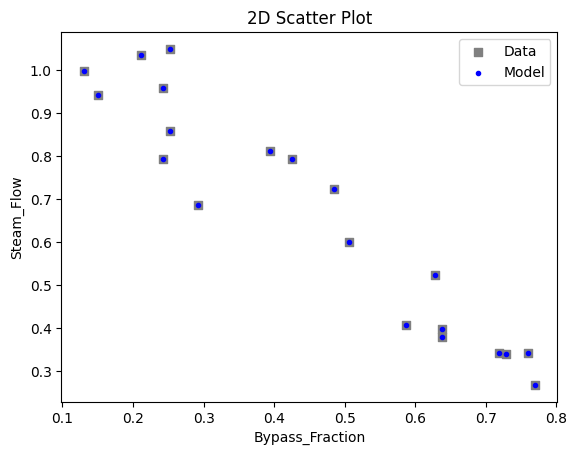

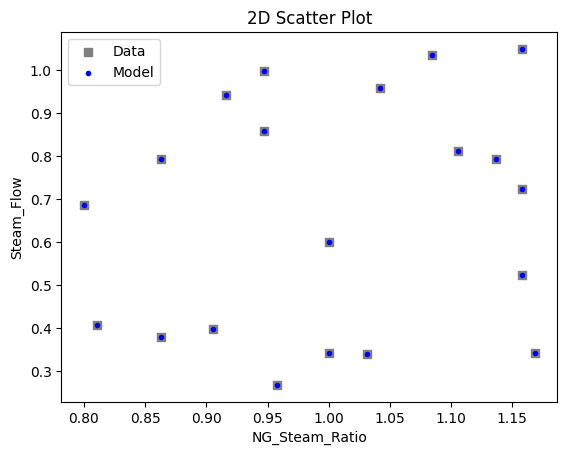

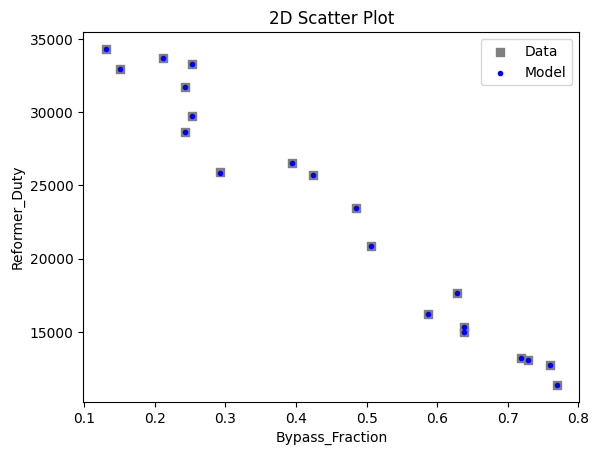

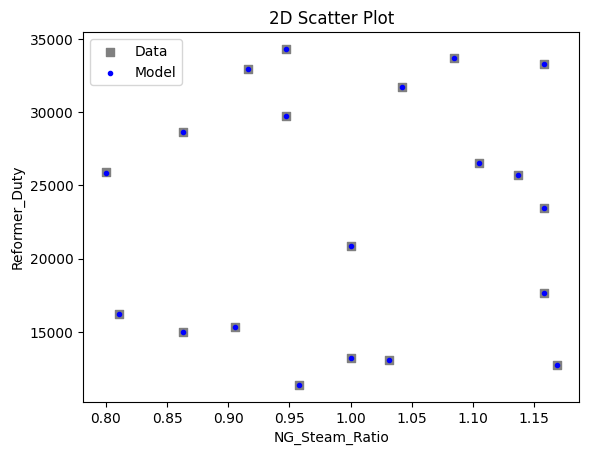

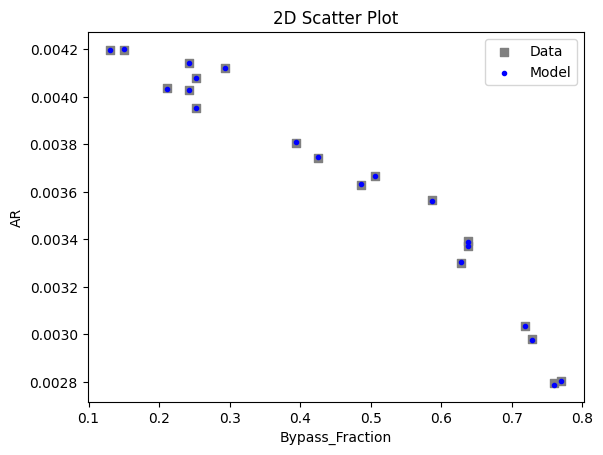

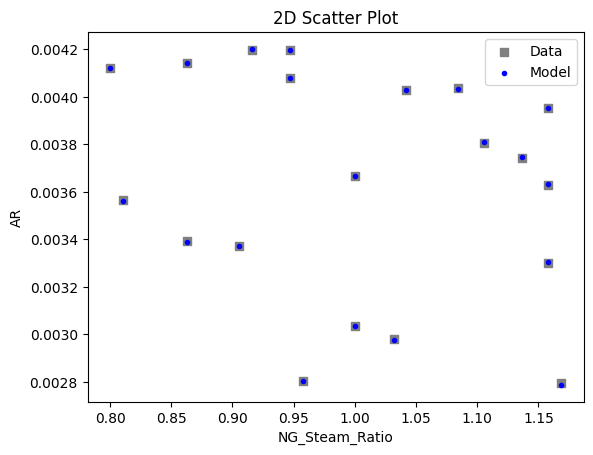

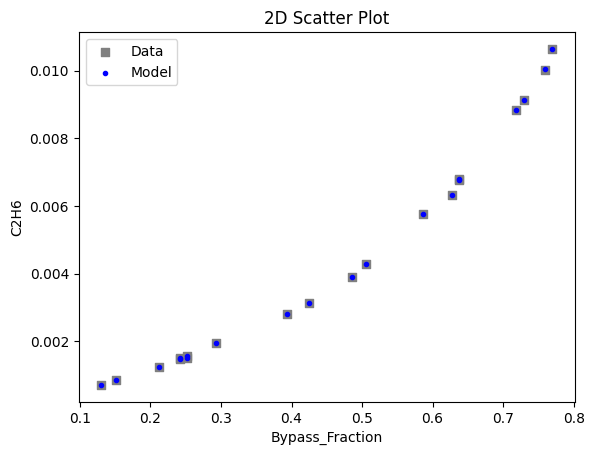

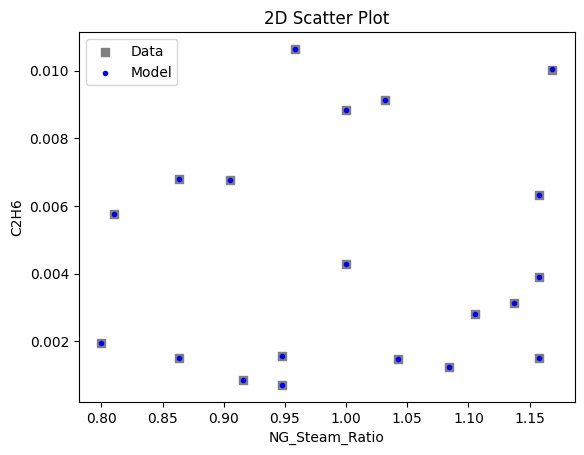

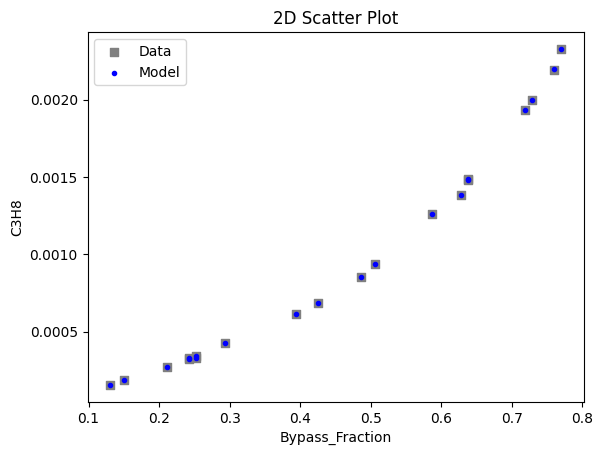

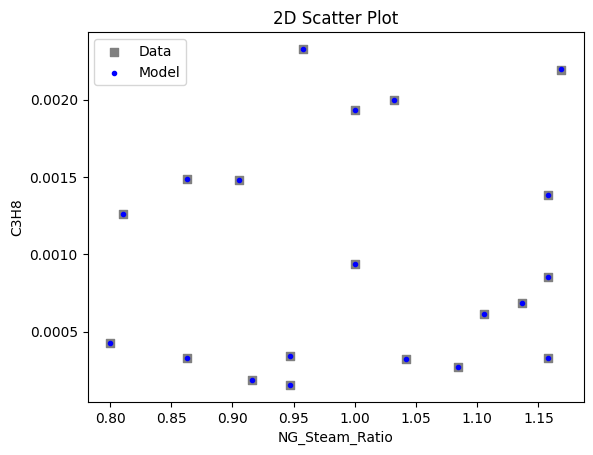

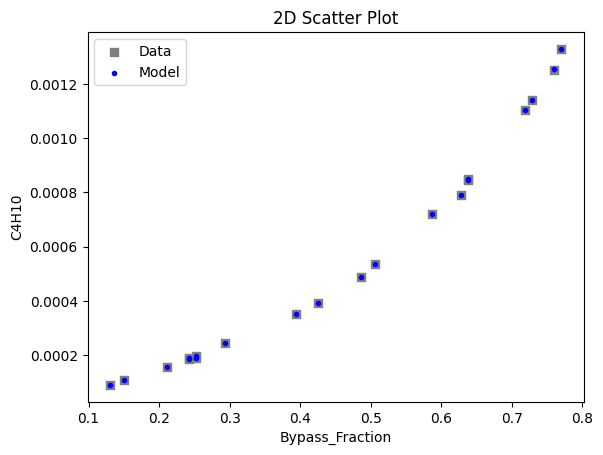

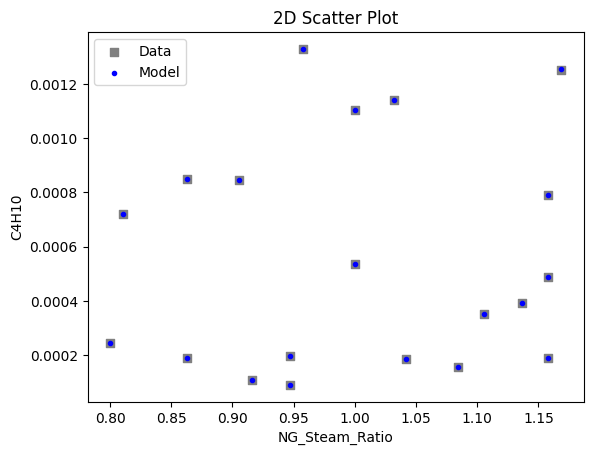

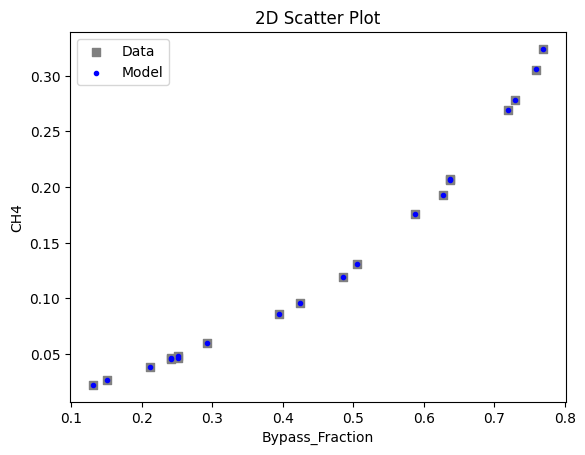

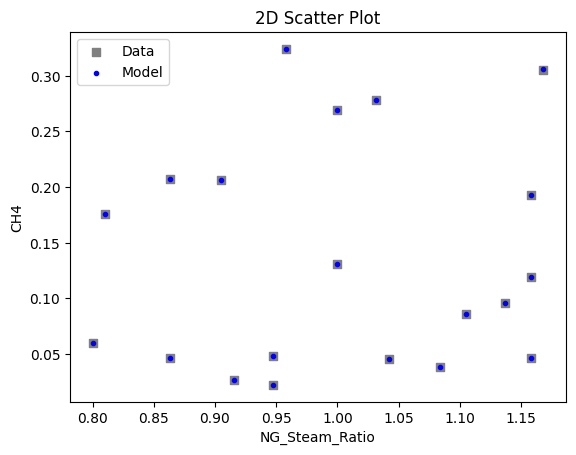

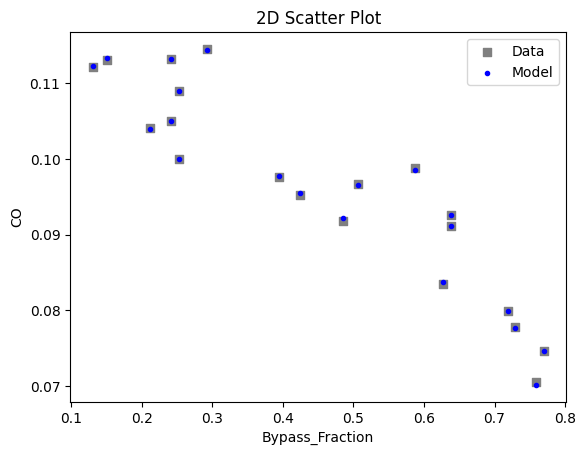

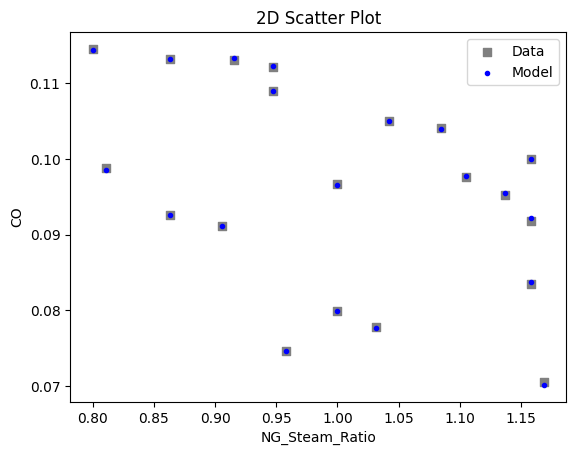

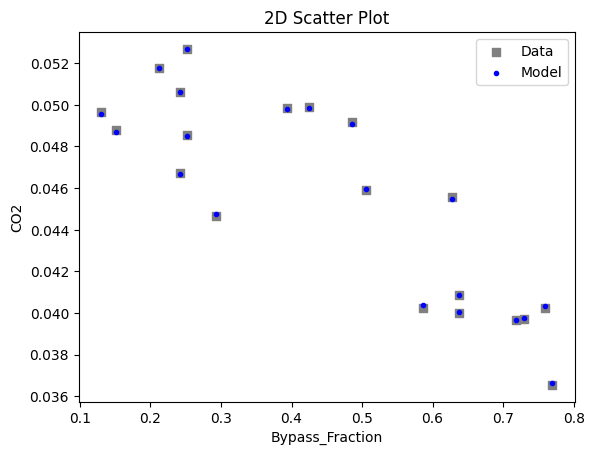

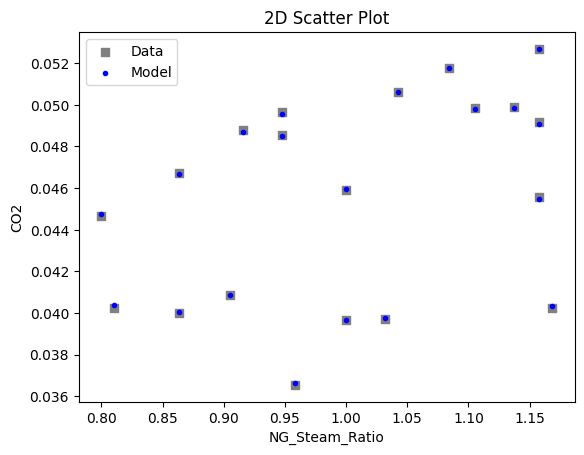

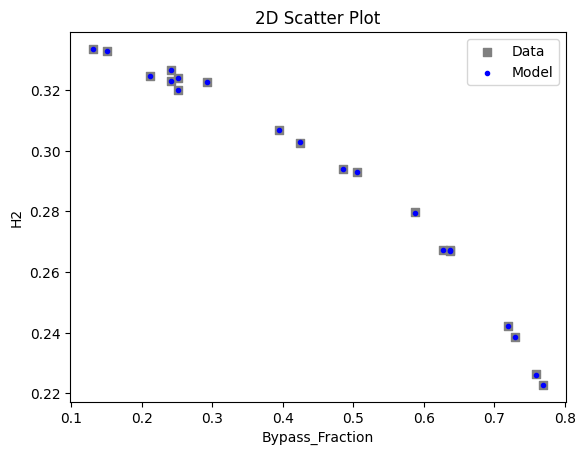

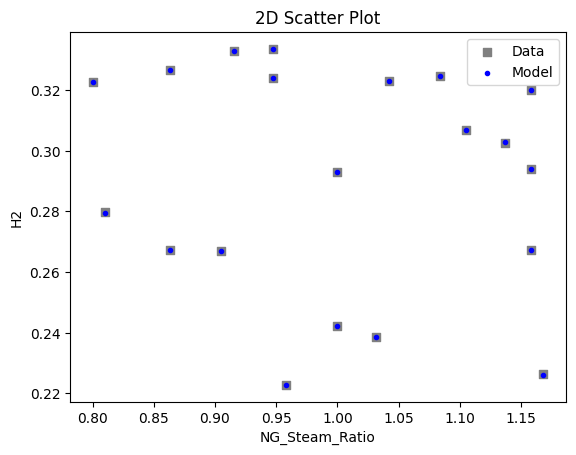

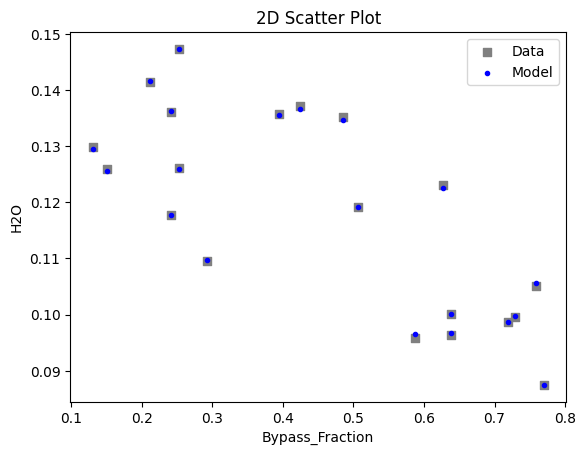

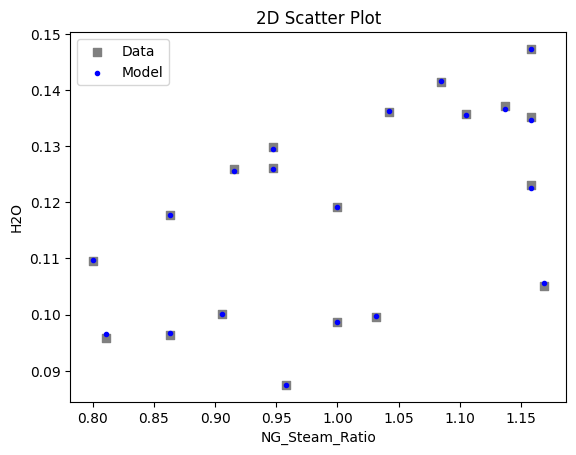

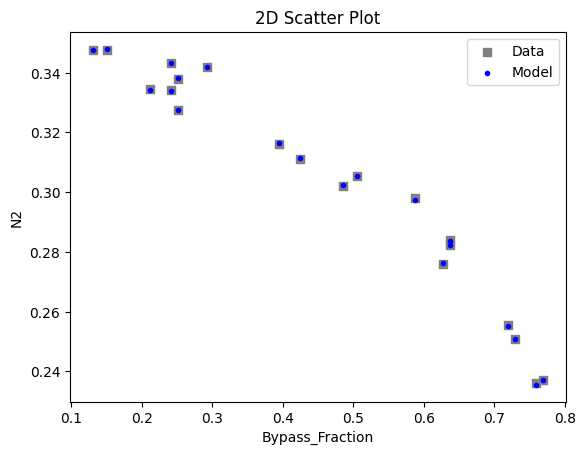

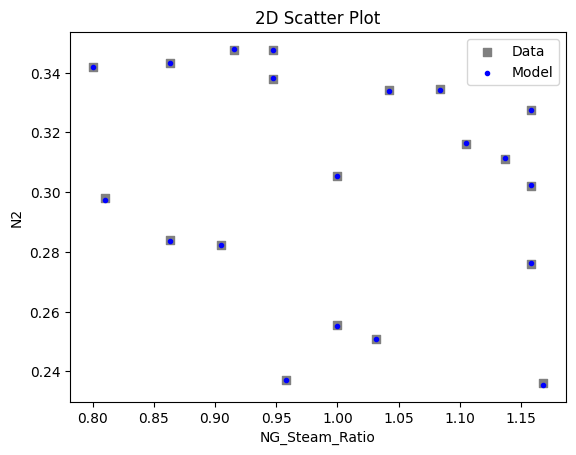

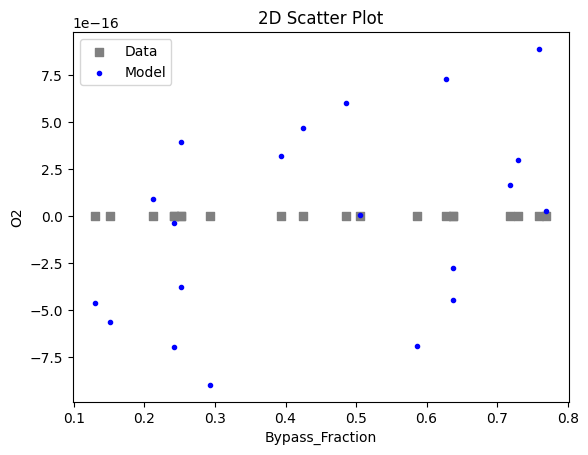

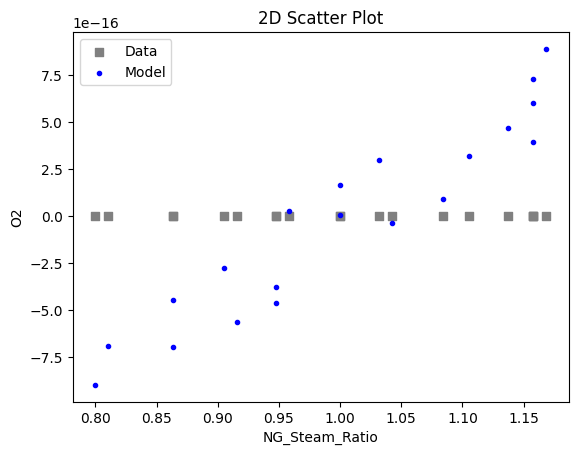

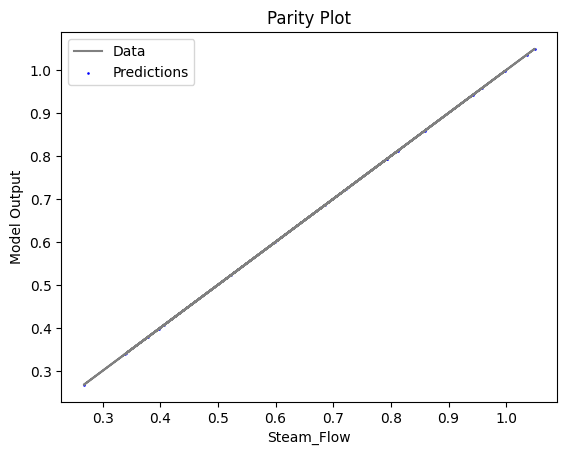

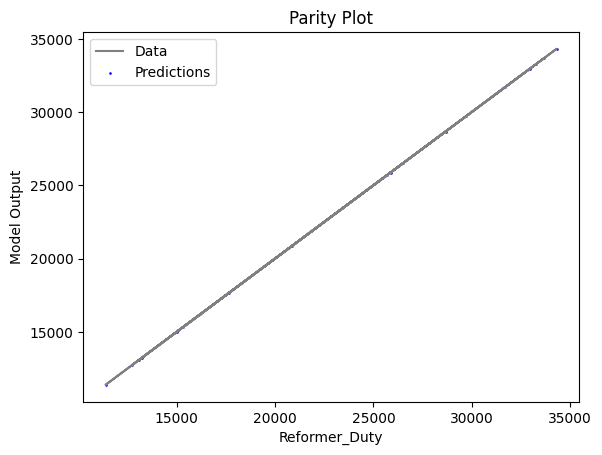

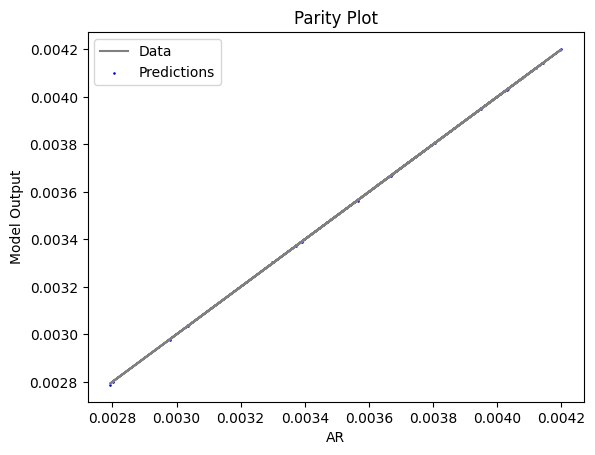

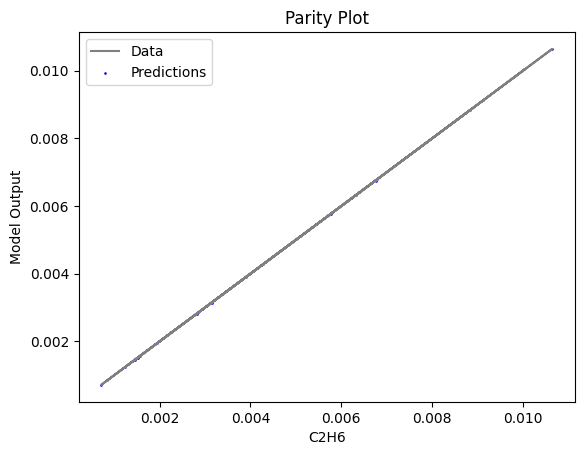

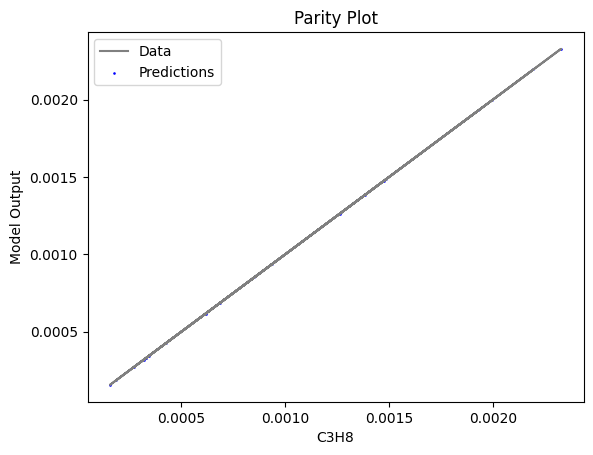

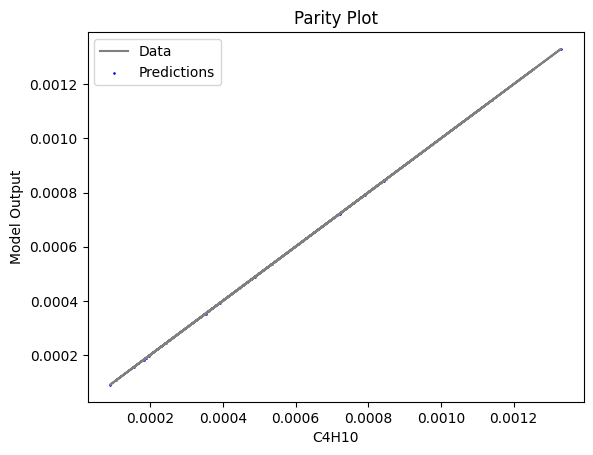

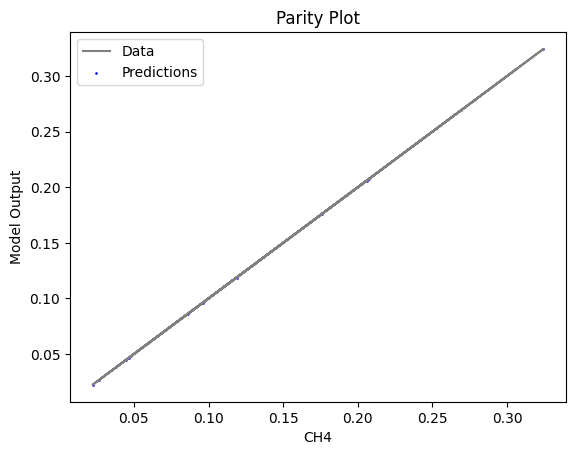

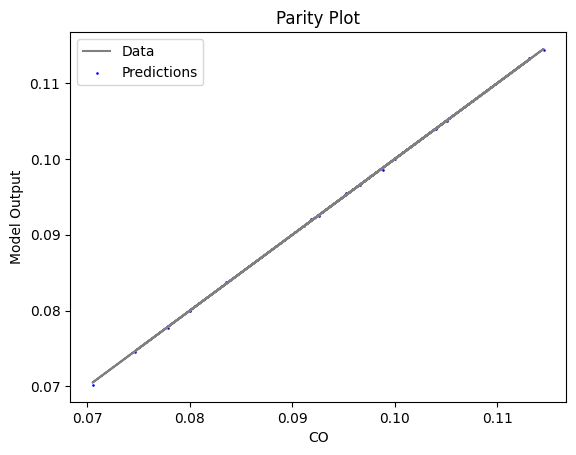

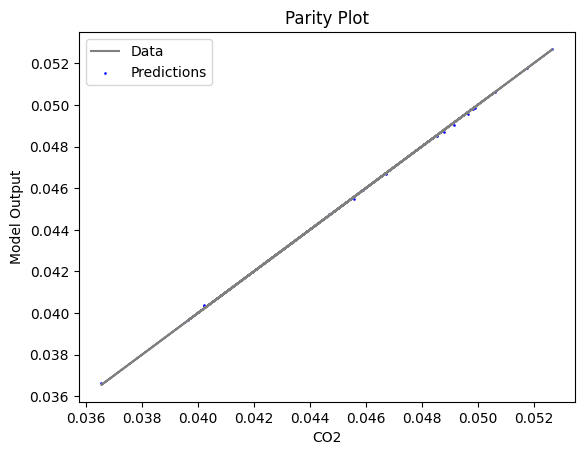

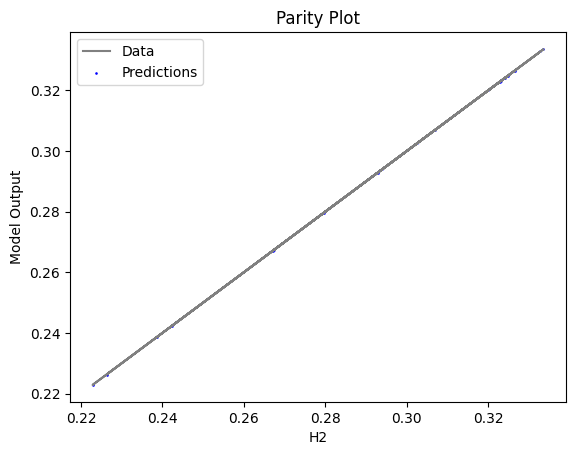

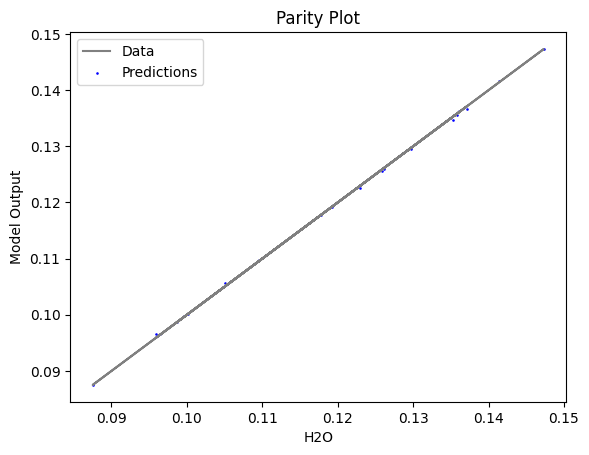

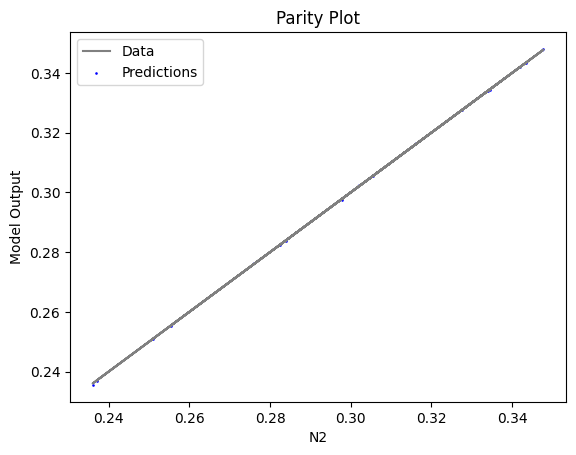

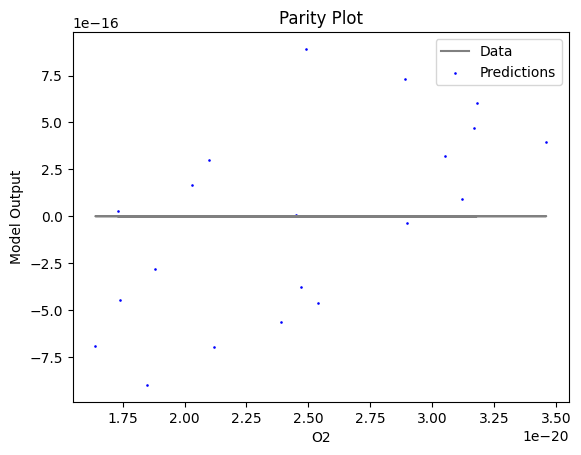

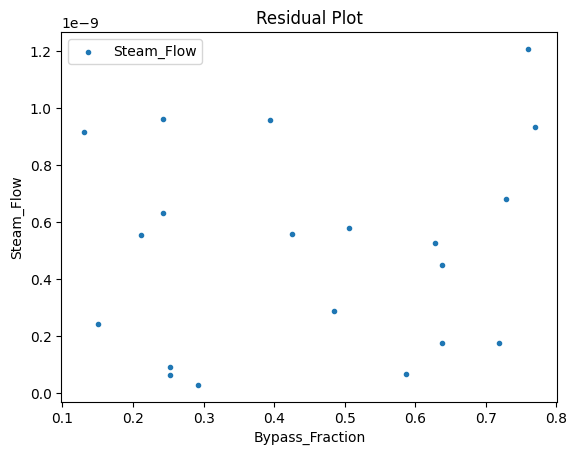

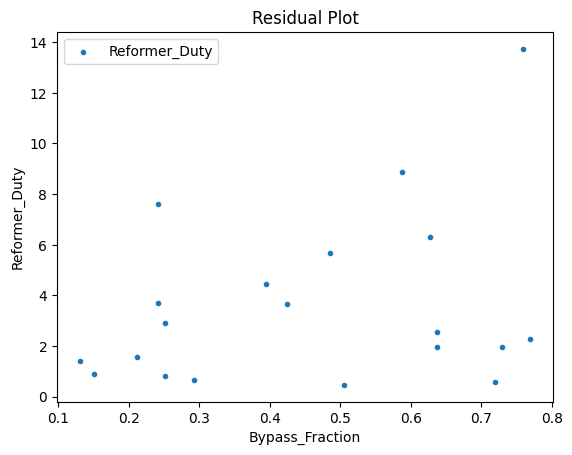

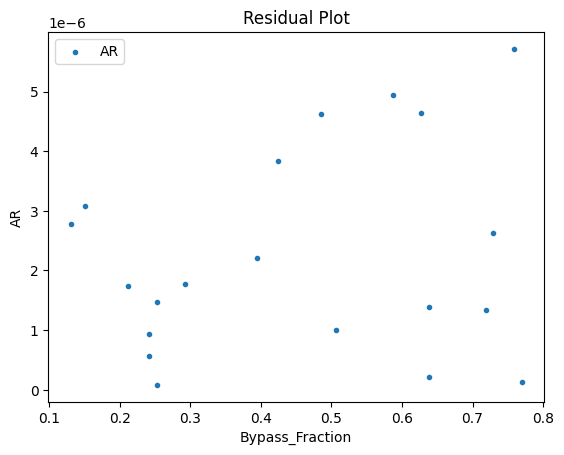

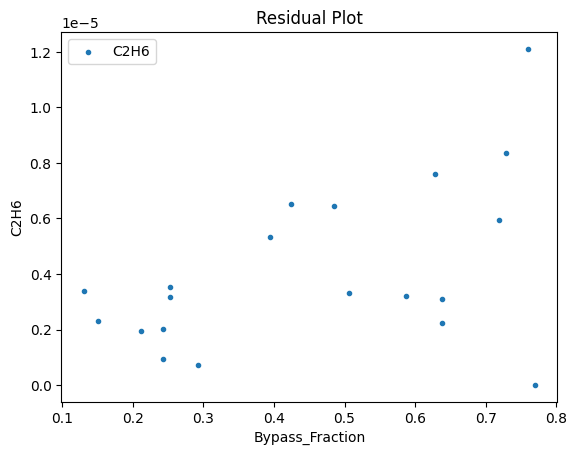

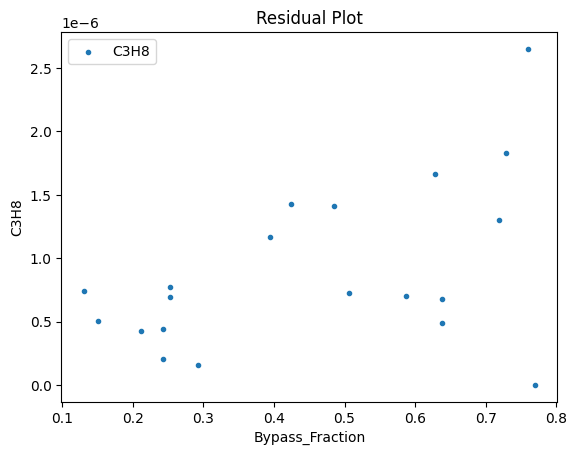

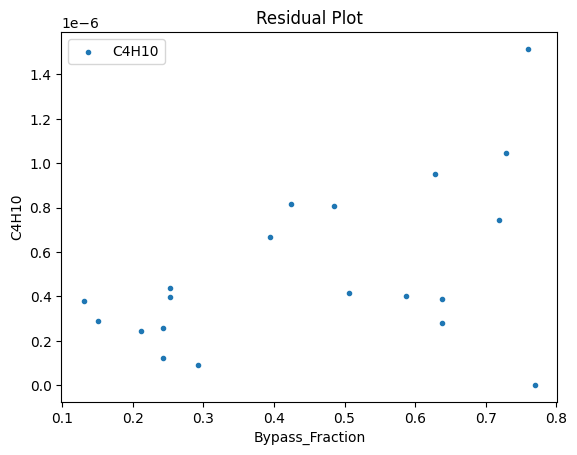

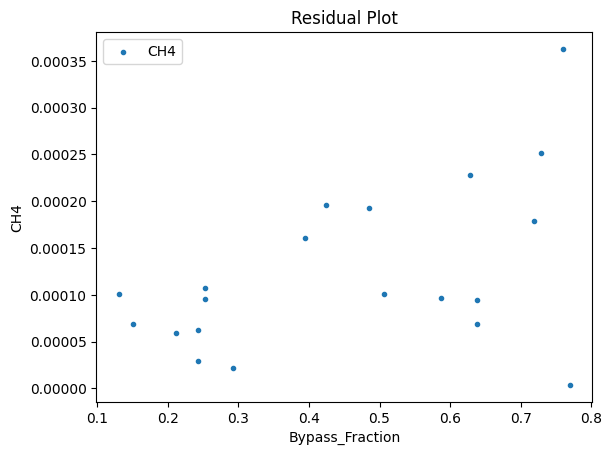

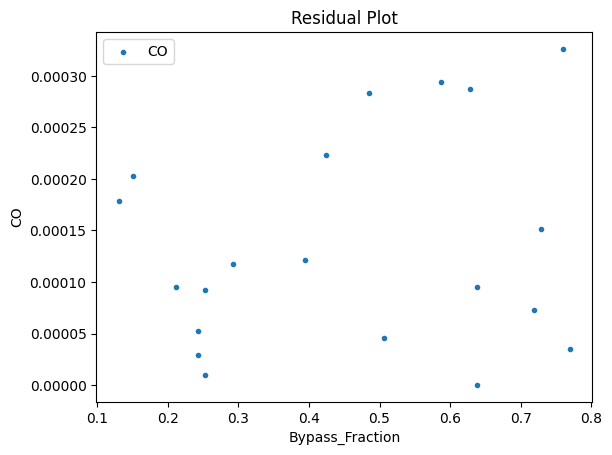

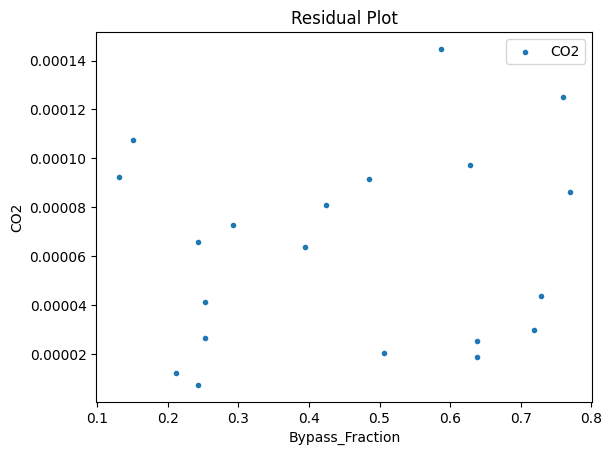

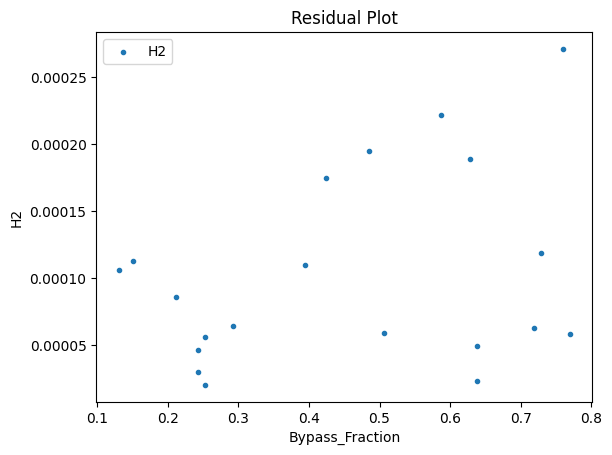

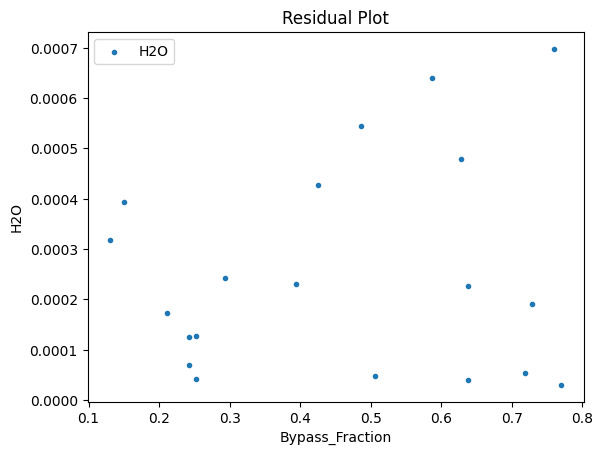

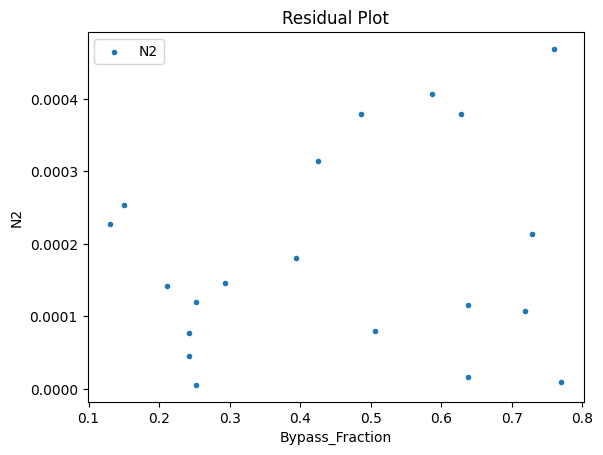

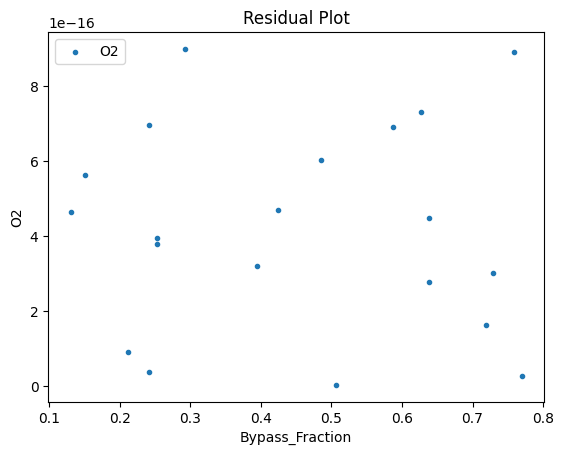

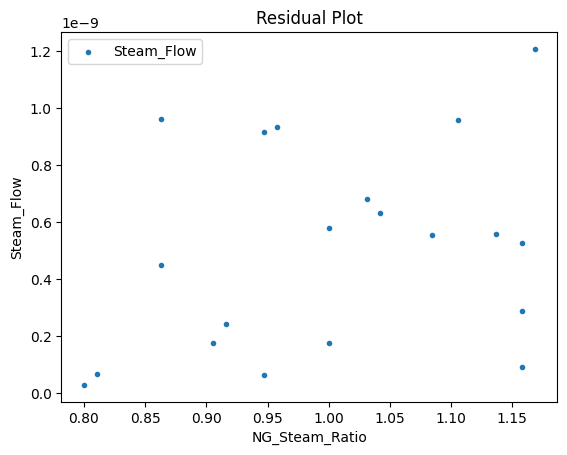

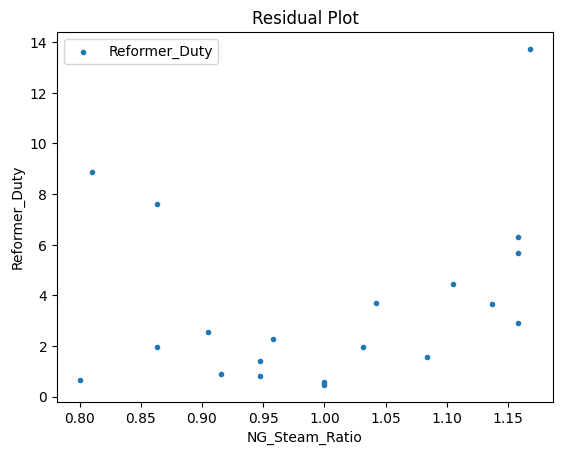

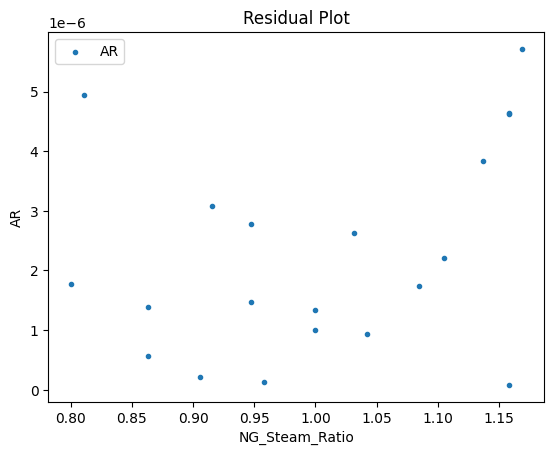

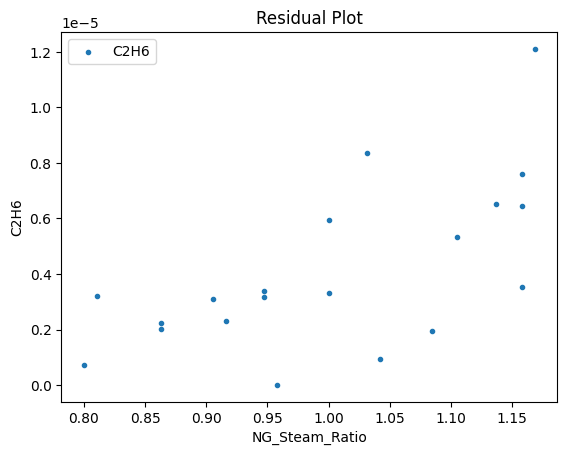

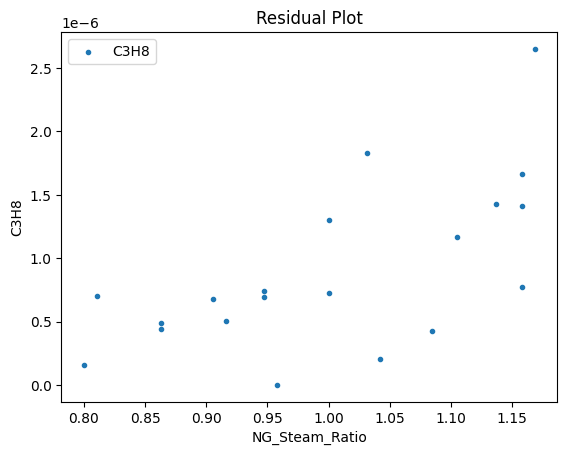

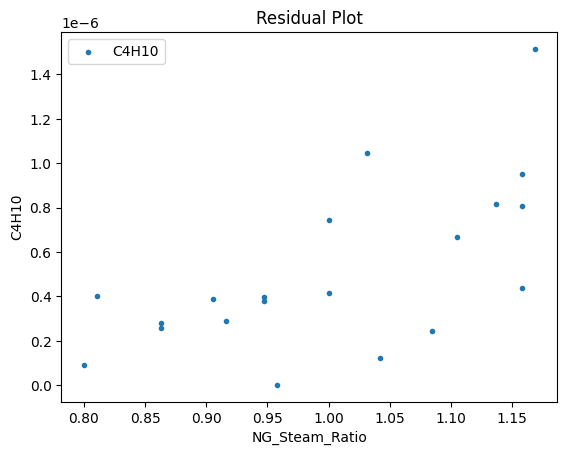

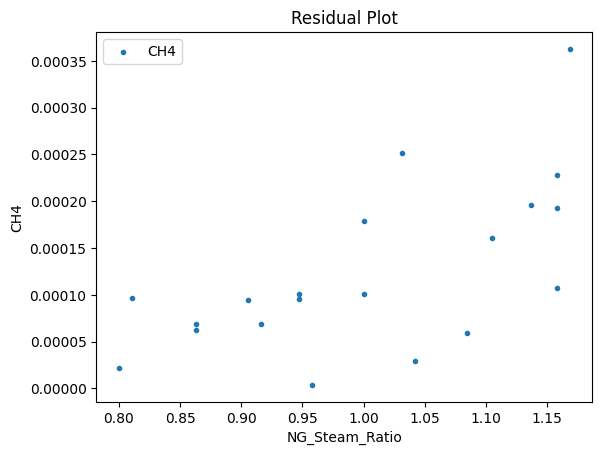

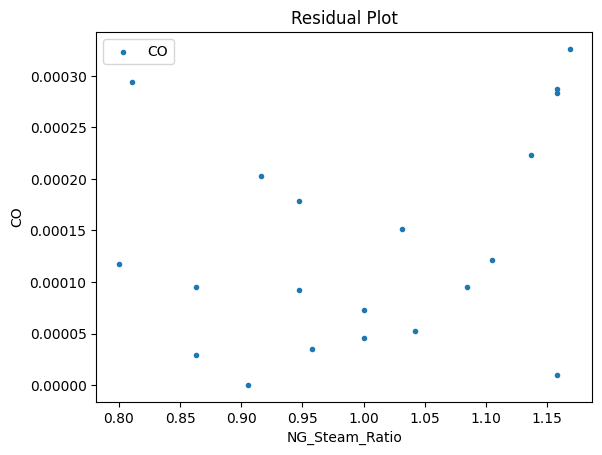

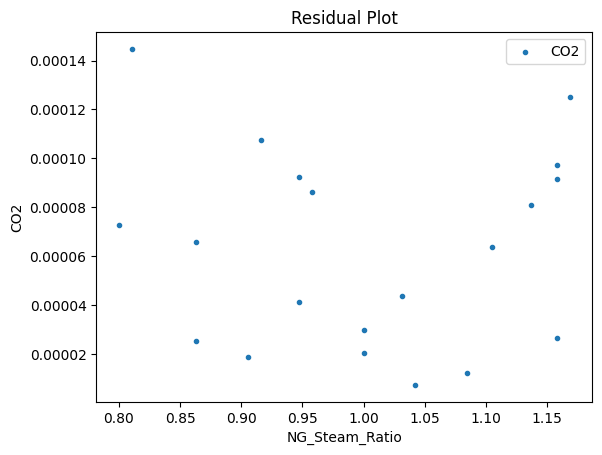

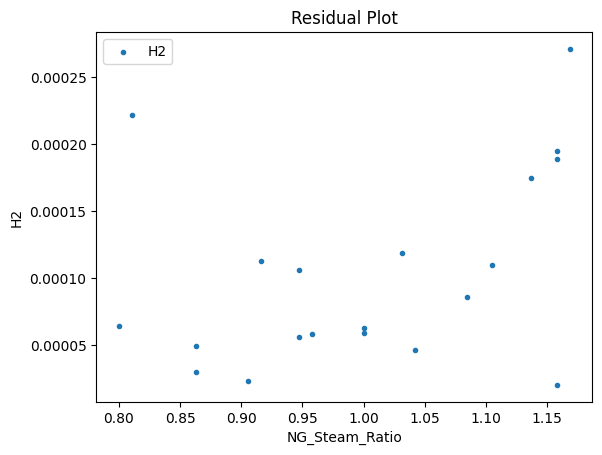

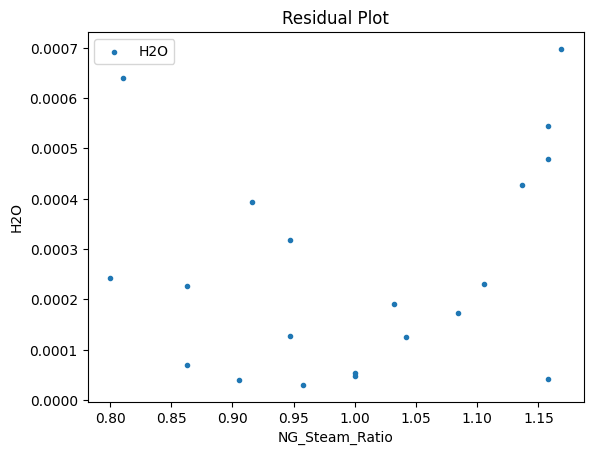

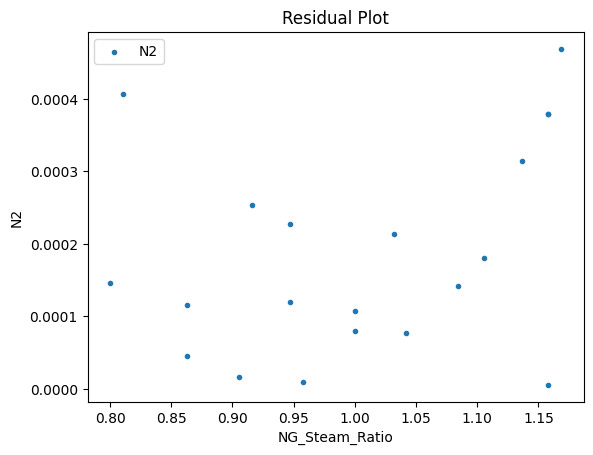

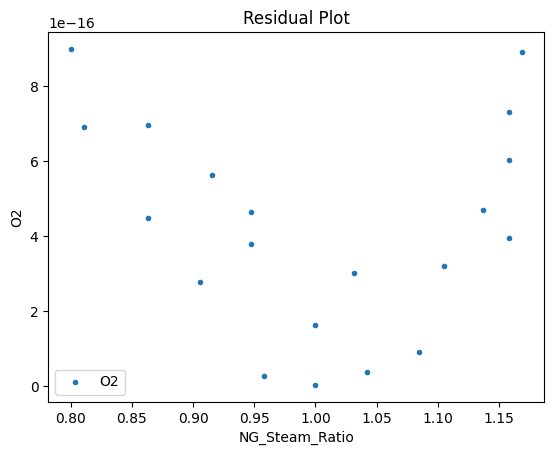

In [7]:
# visualize with IDAES surrogate plotting tools
surrogate_scatter2D(poly_surr, data_validation, filename="pysmo_poly_val_scatter2D.pdf")
surrogate_parity(poly_surr, data_validation, filename="pysmo_poly_val_parity.pdf")
surrogate_residual(poly_surr, data_validation, filename="pysmo_poly_val_residual.pdf")

In [8]:
# create the IDAES model and flowsheet
m = ConcreteModel()
m.fs = FlowsheetBlock(dynamic=False)

# create flowsheet input variables
m.fs.bypass_frac = Var(
    initialize=0.80, bounds=[0.1, 0.8], doc="natural gas bypass fraction"
)
m.fs.ng_steam_ratio = Var(
    initialize=0.80, bounds=[0.8, 1.2], doc="natural gas to steam ratio"
)

# create flowsheet output variables
m.fs.steam_flowrate = Var(initialize=0.2, doc="steam flowrate")
m.fs.reformer_duty = Var(initialize=10000, doc="reformer heat duty")
m.fs.AR = Var(initialize=0, doc="AR fraction")
m.fs.C2H6 = Var(initialize=0, doc="C2H6 fraction")
m.fs.C3H8 = Var(initialize=0, doc="C3H8 fraction")
m.fs.C4H10 = Var(initialize=0, doc="C4H10 fraction")
m.fs.CH4 = Var(initialize=0, doc="CH4 fraction")
m.fs.CO = Var(initialize=0, doc="CO fraction")
m.fs.CO2 = Var(initialize=0, doc="CO2 fraction")
m.fs.H2 = Var(initialize=0, doc="H2 fraction")
m.fs.H2O = Var(initialize=0, doc="H2O fraction")
m.fs.N2 = Var(initialize=0, doc="N2 fraction")
m.fs.O2 = Var(initialize=0, doc="O2 fraction")

# create input and output variable object lists for flowsheet
inputs = [m.fs.bypass_frac, m.fs.ng_steam_ratio]
outputs = [
    m.fs.steam_flowrate,
    m.fs.reformer_duty,
    m.fs.AR,
    m.fs.C2H6,
    m.fs.C4H10,
    m.fs.C3H8,
    m.fs.CH4,
    m.fs.CO,
    m.fs.CO2,
    m.fs.H2,
    m.fs.H2O,
    m.fs.N2,
    m.fs.O2,
]

# create the Pyomo/IDAES block that corresponds to the surrogate
# PySMO

# capture long output (not required to use surrogate API)
stream = StringIO()
oldstdout = sys.stdout
sys.stdout = stream

surrogate = PysmoSurrogate.load_from_file("pysmo_poly_surrogate.json")
m.fs.surrogate = SurrogateBlock(concrete=True)
m.fs.surrogate.build_model(surrogate, input_vars=inputs, output_vars=outputs)

# revert back to normal output capture - don't need to print PySMO load output
sys.stdout = oldstdout

# fix input values and solve flowsheet
m.fs.bypass_frac.fix(0.5)
m.fs.ng_steam_ratio.fix(1)

solver = SolverFactory("ipopt")
status_obj, solved, iters, time, *_ = _run_ipopt_with_stats(m, solver)

2023-02-18 11:58:28 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=poly


Ipopt 3.13.2: output_file=C:\Users\dang\AppData\Local\Temp\tmpt5mkmns3ipopt_out
max_iter=500
max_cpu_time=120


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
      

In [9]:
print("Model status: ", status_obj)
print("Solution optimal: ", solved)
print("IPOPT iterations: ", iters)
print("IPOPT runtime: ", time)

print()
print("Steam flowrate = ", value(m.fs.steam_flowrate))
print("Reformer duty = ", value(m.fs.reformer_duty))
print("Mole Fraction Ar = ", value(m.fs.AR))
print("Mole Fraction C2H6 = ", value(m.fs.C2H6))
print("Mole Fraction C3H8 = ", value(m.fs.C3H8))
print("Mole Fraction C4H10 = ", value(m.fs.C4H10))
print("Mole Fraction CH4 = ", value(m.fs.CH4))
print("Mole Fraction CO = ", value(m.fs.CO))
print("Mole Fraction CO2 = ", value(m.fs.CO2))
print("Mole Fraction H2 = ", value(m.fs.H2))
print("Mole Fraction H2O = ", value(m.fs.H2O))
print("Mole Fraction N2 = ", value(m.fs.N2))
print("Mole Fraction O2 = ", value(m.fs.O2))

Model status:  
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 13
  Number of variables: 13
  Sense: unknown
Solver: 
- Status: ok
  Message: Ipopt 3.13.2\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.0571599006652832
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

Solution optimal:  True
IPOPT iterations:  1
IPOPT runtime:  0

Steam flowrate =  0.6059308502504166
Reformer duty =  21072.85831149541
Mole Fraction Ar =  0.0036780507475182647
Mole Fraction C2H6 =  0.004190489068046699
Mole Fraction C3H8 =  0.0005238104416202226
Mole Fraction C4H10 =  0.0009166694527835278
Mole Fraction CH4 =  0.1279560262696421
Mole Fraction CO =  0.09690372428907076
Mole Fraction CO2 =  0.046050387861398784
Mole Fraction H2 =  0.2938034584382847
Mole Fraction H2O =  0.11962800151030754
Mole Fraction N2 =  0.3063364593566888
Mole Fraction O2 =  0.0


In [10]:
# unfix input values and add the objective/constraint to the model
m.fs.bypass_frac.unfix()
m.fs.ng_steam_ratio.unfix()
m.fs.obj = Objective(expr=m.fs.H2, sense=maximize)
m.fs.con = Constraint(expr=m.fs.N2 <= 0.34)

# solve the model
tmr = TicTocTimer()
status = solver.solve(m, tee=True)
solve_time = tmr.toc("solve")

# print and check results
assert abs(value(m.fs.H2) - 0.33) <= 0.01
assert value(m.fs.N2 <= 0.4 + 1e-8)
print("Model status: ", status)
print("Solve time: ", solve_time)
for var in inputs:
    print(var.name, ": ", value(var))
for var in outputs:
    print(var.name, ": ", value(var))

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://


Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............:  -3.3170173683456011e-01   -3.3170173683456011e-01
Dual infeasibility......:   2.9514571535393342e-14    2.9514571535393342e-14
Constraint violation....:   4.1754774675910625e-12    1.5716068446636200e-09
Complementarity.........:   2.5059040451291435e-09    2.5059040451291435e-09
Overall NLP error.......:   2.5059040451291435e-09    2.5059040451291435e-09


Number of objective function evaluations             = 13
Number of objective gradient evaluations             = 13
Number of equality constraint evaluations            = 13
Number of inequality constraint evaluations          = 13
Number of equality constraint Jacobian evaluations   = 13
Number of inequality constraint Jacobian evaluations = 13
Number of Lagrangian Hessian evaluations             = 12
Total CPU secs in IPOPT (w/o function evaluations)   =      0.000
Total CPU secs in NLP function evaluati

[+   0.10] solve
Model status:  
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 14
  Number of variables: 15
  Sense: unknown
Solver: 
- Status: ok
  Message: Ipopt 3.13.2\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.07233810424804688
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

Solve time:  0.10353419999592006
fs.bypass_frac :  0.10000005480304125
fs.ng_steam_ratio :  1.1187839608910546
fs.steam_flowrate :  1.2202302151097162
fs.reformer_duty :  38966.187872296025
fs.AR :  0.004107201346492653
fs.C2H6 :  0.0005200338698070412
fs.C4H10 :  0.00011375725259164065
fs.C3H8 :  6.501454955610169e-05
fs.CH4 :  0.01622266856767099
fs.CO :  0.10484545788138692
fs.CO2 :  0.05348959122571818
fs.H2 :  0.3317017368345601
fs.H2O :  0.14884686191198102
fs.N2 :  0.3400000042498812
fs.O2 :  1.2142100367041826e-16
